In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCS2(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

### Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [111]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['for_jan18','for_jan18_PR','backVS_jan18','backrosVS_jan18','backharoVS_jan18','forrosVS_jan18','backVS_jan18','forharoVS_jan18','backsjcVS_jan18','forsjcVS_jan18','for_jan18_PR','backharoPR_jan18','backrosPR_jan18','backPR_jan18','forharoPR_jan18','forrosPR_jan18','foradm_jan18','backadm_jan18']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2018,12,11)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


### Shifting functions

In [6]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

In [7]:
def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

#### Rosario

In [8]:
VStoRosl = sectransp_2018['for_jan18'][4]
VStoRosbl = sectransp_2018['backrosVS_jan18'][4]

VStoRos = pd.Series(VStoRosl,index=datelist_vs)
VStoRosb = pd.Series(VStoRosbl,index=datelist_vs)

In [9]:
#Arbitrarily chose 0.5 and 0.5 for shift

VStoRos_sh = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.5,0.5)
VStoRosb_sh = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.5,-0.5)

0.8024700681362394


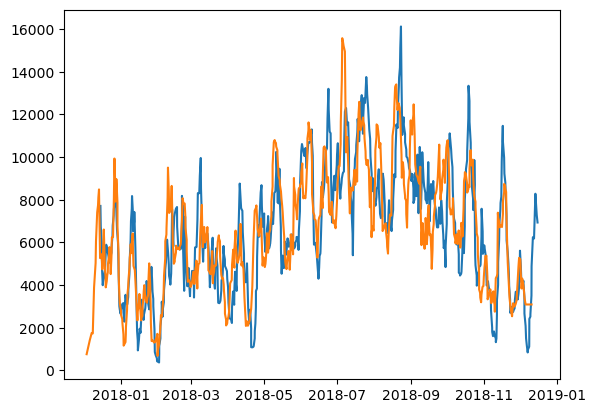

In [10]:
d1,d2,c,VStoRos_avg = merge(VStoRos_sh,VStoRosb_sh)
print(c)

plt.plot(d1.Transport)
plt.plot(d2.Transport)

Compare age of both ways

In [11]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,base,factor)
        dfr2 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],average = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.82:
            print (base, factor, corr_arr[i, j])
        

0.0 0.45 0.8271936672008791
0.05 0.45 0.8289922292029412
0.1 0.45 0.8265235621500514
0.15000000000000002 0.45 0.8250261270823152
0.2 0.45 0.8257597609889438
0.25 0.45 0.8215967706849564
0.30000000000000004 0.45 0.8228026072183194
0.35000000000000003 0.45 0.8224250692188828
0.4 0.4 0.8218528974272198
0.45 0.4 0.8277791709182514
0.5 0.4 0.8293403955785482
0.55 0.4 0.8248063259568345
0.6000000000000001 0.4 0.8200603182259993
0.65 0.4 0.8242914363614433
0.7000000000000001 0.4 0.8232121682339053
0.75 0.4 0.8234335603043834
0.8 0.4 0.8207682303173044
0.8500000000000001 0.35000000000000003 0.8217978055183592
0.9 0.35000000000000003 0.828548269655994
0.9500000000000001 0.35000000000000003 0.8259935948689054


Text(0.5, 0, 'Base')

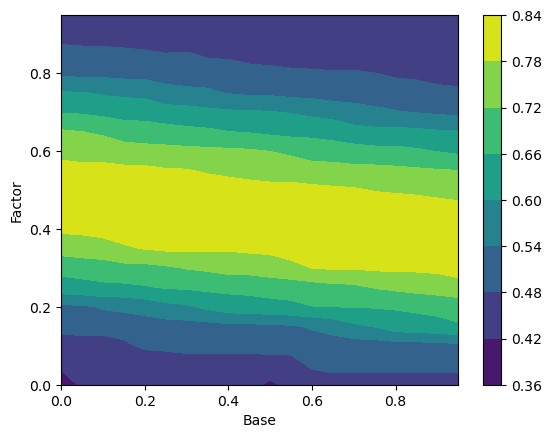

In [12]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

Try to get rid of band and get a more exact point. Equal base and factor maximizes correlation?

Text(0.5, 1.0, 'Age')

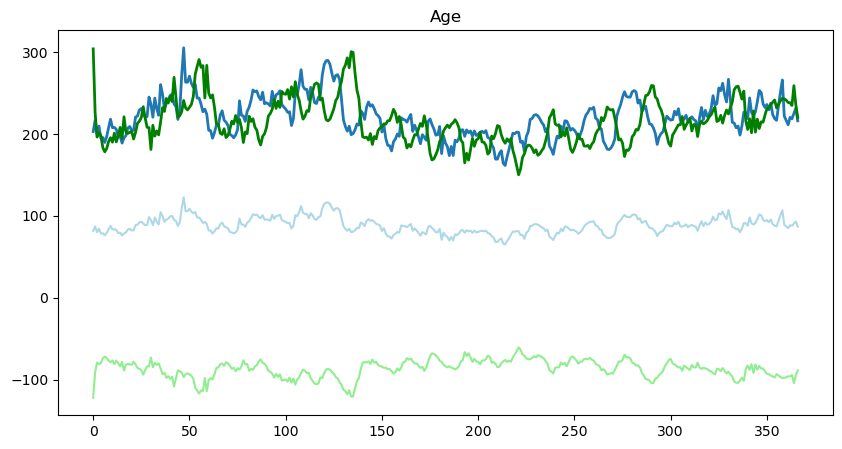

In [13]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [-0.5-0.4*age for age in age_2018['backrosVS_jan18'][4]]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(age_2018['for_jan18'][4],lw=2)
ax.plot(age_2018['backrosVS_jan18'][4],color='g',lw=2)
ax.plot(shift,color='lightblue')
ax.plot(shift2,color='lightgreen')
ax.set_title('Age')

In [14]:
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

print(base_arr[i_base],factor_arr[i_factor])


[0.5] [0.4]


0.8293403955785482


Text(0.5, 1.0, 'Shifted')

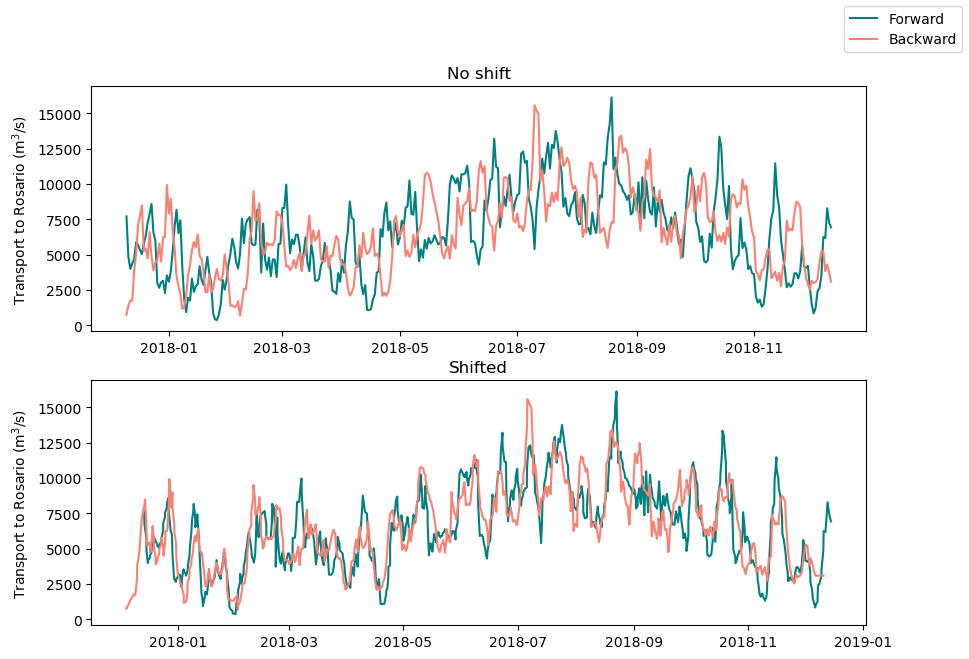

In [15]:
VStoRos_sh = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,base_arr[i_base][0],factor_arr[i_factor][0])
VStoRosb_sh = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-base_arr[i_base][0],-factor_arr[i_factor][0])

VStoRos_m,VStoRosb_m,c,VStoRos_avg = merge(VStoRos_sh,VStoRosb_sh)
print(c)

fig,ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(VStoRos,color='teal')
ax[0].plot(VStoRosb,color='salmon')
ax[1].plot(VStoRos_m.Transport,label='Forward',color='teal')
ax[1].plot(VStoRosb_m.Transport,label='Backward',color='salmon')
fig.legend()
ax[0].set_ylabel(f'Transport to Rosario (m$^3$/s)')
ax[1].set_ylabel(f'Transport to Rosario (m$^3$/s)')
ax[0].set_title('No shift')
ax[1].set_title('Shifted')

Plot shift for different combinations of high correlation (to see how large of variation this is)

0.8271936672008791


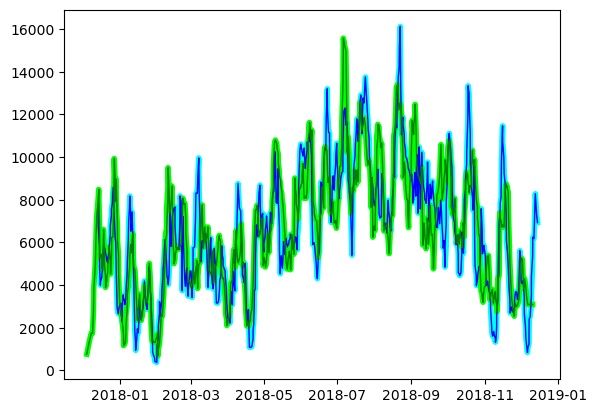

In [16]:
VStoRos_sh2 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0,0.45)
VStoRosb_sh2 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,0,-0.45)

VStoRos_m2,VStoRosb_m2,c,a = merge(VStoRos_sh2,VStoRosb_sh2)
print(c)

plt.plot(VStoRos_m.Transport,lw=4,color='cyan')
plt.plot(VStoRosb_m.Transport,color='lime',lw=4)
plt.plot(VStoRos_m2.Transport,color='blue',lw=1)
plt.plot(VStoRosb_m2.Transport,color='green',lw=1)

0.828548269655994


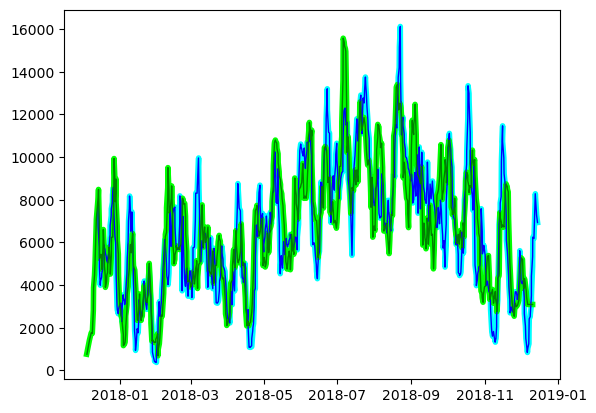

In [17]:
VStoRos_sh3 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.9,0.35)
VStoRosb_sh3 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.9,-0.35)

VStoRos_m3,VStoRosb_m3,c,a = merge(VStoRos_sh3,VStoRosb_sh3)
print(c)

plt.plot(VStoRos_m.Transport,lw=4,color='cyan')
plt.plot(VStoRosb_m.Transport,color='lime',lw=4)
plt.plot(VStoRos_m3.Transport,color='blue',lw=1)
plt.plot(VStoRosb_m3.Transport,color='green',lw=1)

Actually look at how much its being shifted. Also maybe band will be different when looking at yearly scale

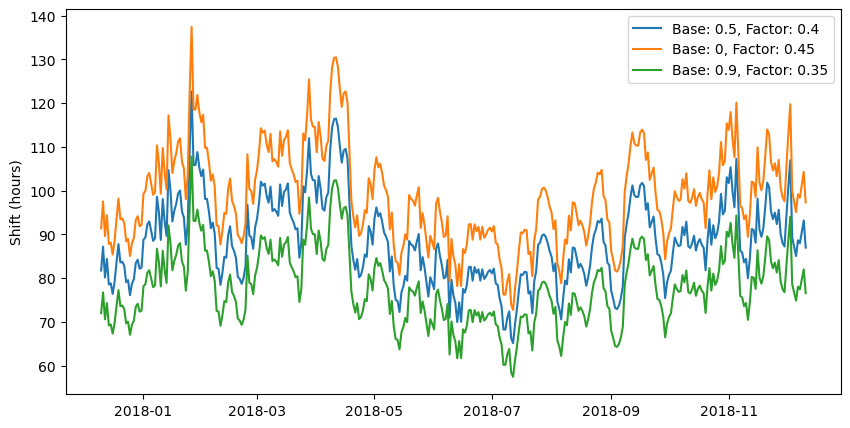

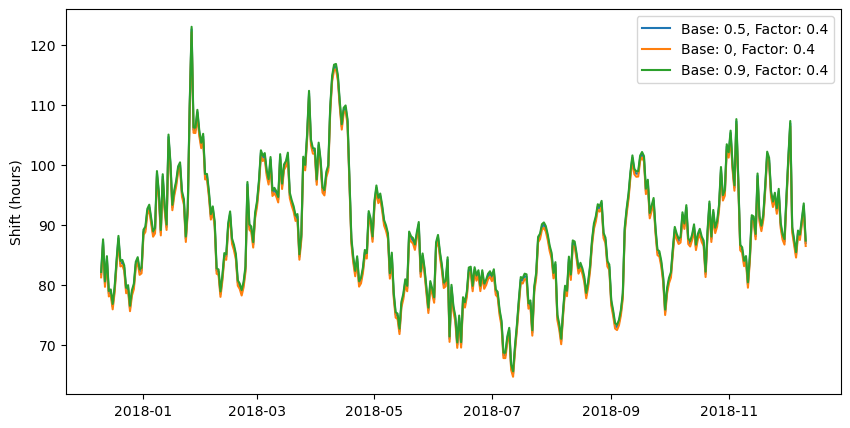

In [18]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [0+0.45*age for age in age_2018['for_jan18'][4]]
shift3= [0.9+0.35*age for age in age_2018['for_jan18'][4]]

plt.figure(figsize=(10,5))
plt.plot(datelist_vs,shift,label=f'Base: 0.5, Factor: 0.4')
plt.plot(datelist_vs,shift2,label=f'Base: 0, Factor: 0.45')
plt.plot(datelist_vs,shift3,label=f'Base: 0.9, Factor: 0.35')
plt.ylabel('Shift (hours)')
plt.legend()

shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [0+0.4*age for age in age_2018['for_jan18'][4]]
shift3= [0.9+0.4*age for age in age_2018['for_jan18'][4]]

plt.figure(figsize=(10,5))
plt.plot(datelist_vs,shift,label=f'Base: 0.5, Factor: 0.4')
plt.plot(datelist_vs,shift2,label=f'Base: 0, Factor: 0.4')
plt.plot(datelist_vs,shift3,label=f'Base: 0.9, Factor: 0.4')
plt.ylabel('Shift (hours)')
plt.legend()


0.8259935948689054


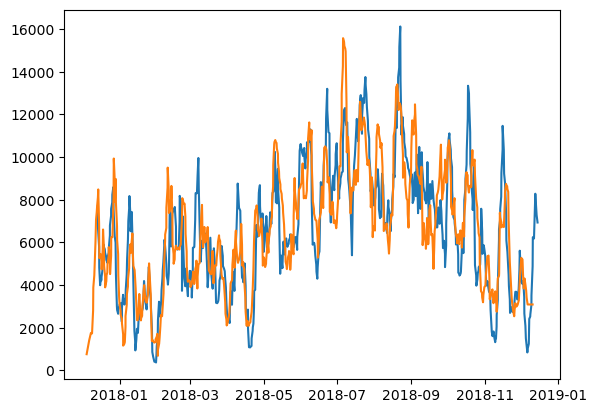

In [19]:
VStoRos_sh3 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.95,0.35)
VStoRosb_sh3 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.95,-0.35)

VStoRos_m3,VStoRosb_m3,c,a = merge(VStoRos_sh3,VStoRosb_sh3)
print(c)

plt.plot(VStoRos_m3.Transport)
plt.plot(VStoRosb_m3.Transport)

0.8271936672008791


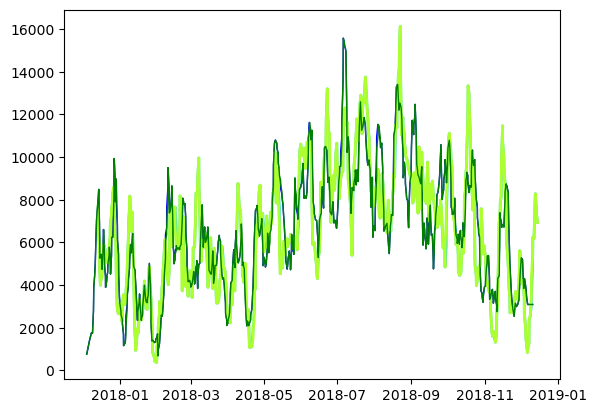

In [20]:
VStoRos_sh4 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0,0.45)
VStoRosb_sh4 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,0,-0.45)

VStoRos_m4,VStoRosb_m4,c,a = merge(VStoRos_sh4,VStoRosb_sh4)
print(c)

plt.plot(VStoRos_m.Transport,color='turquoise',lw=2)
plt.plot(VStoRosb_m.Transport,color='blue',lw=1)
plt.plot(VStoRos_m4.Transport,color='greenyellow',lw=2)
plt.plot(VStoRosb_m4.Transport,color='green',lw=1)

Although the change in shift is minor: **The maximum correlation is when base = 0.50 and factor = 0.40**

#### Look at shift with Haro

In [21]:
VStoHarol = sectransp_2018['for_jan18'][6]
VStoHarobl = sectransp_2018['backharoVS_jan18'][6]

VStoHaro = pd.Series(VStoHarol,index=datelist_vs)
VStoHarob = pd.Series(VStoHarobl,index=datelist_vs)

In [22]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(VStoHarob,age_2018['backrosVS_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.88:
            print (base, factor, corr_arr[i, j])

0.45 0.15000000000000002 0.8831074661446254
0.5 0.15000000000000002 0.8818428061535413
0.65 0.1 0.8838219813783946
0.7000000000000001 0.1 0.888294521941459
0.75 0.1 0.8857246039634794
0.8 0.1 0.8855811710318306
0.8500000000000001 0.05 0.888294521941459
0.8500000000000001 0.1 0.8853172197347154
0.9 0.05 0.8855487300633135
0.9 0.1 0.8853256479946595
0.9500000000000001 0.05 0.8855487300633135
0.9500000000000001 0.1 0.8847515643386199


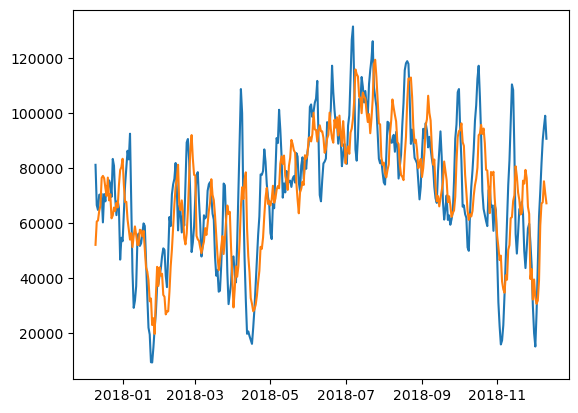

In [23]:
plt.plot(VStoHaro)
plt.plot(VStoHarob)

Text(0.5, 0, 'Base')

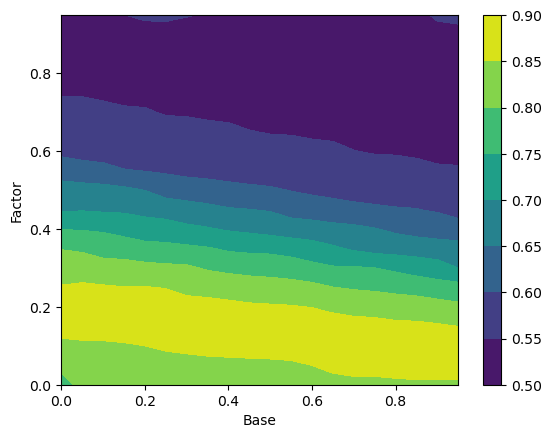

In [24]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

In [25]:
i_base_haro,i_factor_haro = np.where(corr_arr==np.max(corr_arr))

base_haro = base_arr[i_base_haro]
factor_haro = factor_arr[i_factor_haro]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[0.7  0.85] [0.1  0.05]


Max correlation occurs at 2 locations - compare

In [26]:
VStoHaro_sh2 = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base_haro[1],factor_haro[1])
VStoHarob_sh2 = shift_time(VStoHarob,age_2018['backharoVS_jan18'][6],datelist_vs,-base_haro[1],-factor_haro[1])

VStoHaro_m2,VStoHarob_m2,c2,VStoHaro_avg = merge(VStoHaro_sh2,VStoHarob_sh2)
print(c2)

VStoHaro_sh = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base_haro[0],factor_haro[0])
VStoHarob_sh = shift_time(VStoHarob,age_2018['backharoVS_jan18'][6],datelist_vs,-base_haro[0],-factor_haro[0])

VStoHaro_m,VStoHarob_m,c,VStoHaro_avg2 = merge(VStoHaro_sh,VStoHarob_sh)
print(c)

0.8885137838951079
0.8885137838951079


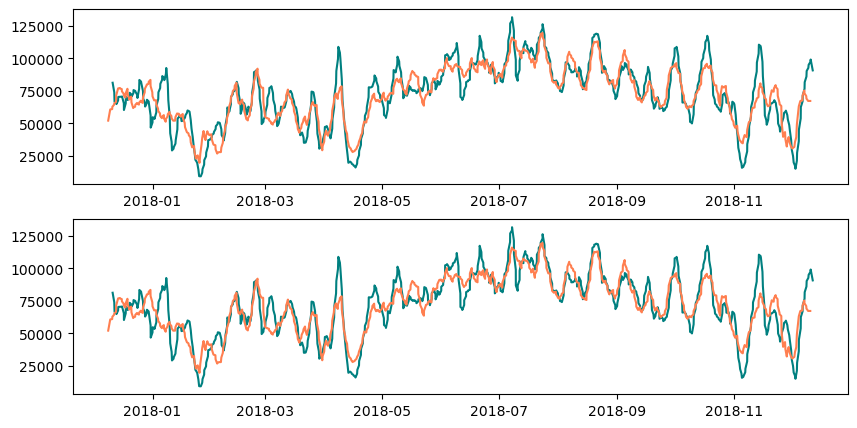

In [27]:
fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))

ax.plot(VStoHaro_m,color='teal')
ax.plot(VStoHarob_m,color='coral')

ax2.plot(VStoHaro_m,color='teal')
ax2.plot(VStoHarob_m,color='coral')

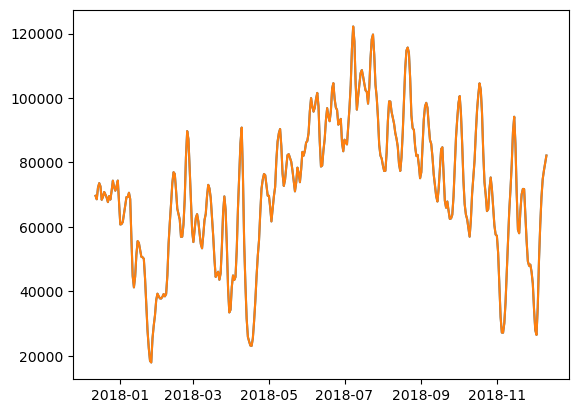

In [28]:
plt.plot(VStoHaro_avg2.dropna())
plt.plot(VStoHaro_avg.dropna())

Pretty much the exact same

#### Next steps:
 - look at correlations with tides and density difference with this shift

### Importing tidal and density difference data

In [163]:
# Importing density and tidal data

density = pd.read_csv('sigma_2018_202111_mean.csv')
dens_diff = np.array(density.south - density.north)
date_dens = pd.to_datetime(density['Unnamed: 0'])

density_ros = pd.read_csv('sigma_2018_rosariovs_202111_mean.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)
density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)
density_rosfpr = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfpr = density_rosfpr.north - density_rosfpr.south # north/south swapped for this one
density_harofpr = pd.read_csv('sigma_2018_haropr_202111_mean.csv')
dens_diff_harofpr = density_harofpr.north - density_harofpr.south # north/south swapped for this one
density_rosfprv2 = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfprv2 = density_rosfprv2.north - density_rosfprv2.south
density_sjcvs = pd.read_csv('sigma_2018_sjcvs_202111.csv')
dens_diff_sjc = np.array(density_sjcvs.north - density_sjcvs.south)
density_admvs = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2018_vsadm_202111_mean.csv')
dens_diff_adm = np.array(density_admvs.south - density_admvs.north)

tides = pd.read_csv('low_pass_tide.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2018,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)

#Confirm that the lengths are the same
print(len(datelist_dens))
print(date_dens.shape)

730
(730,)
1095
(1095,)


Text(0.5, 1.0, 'Age')

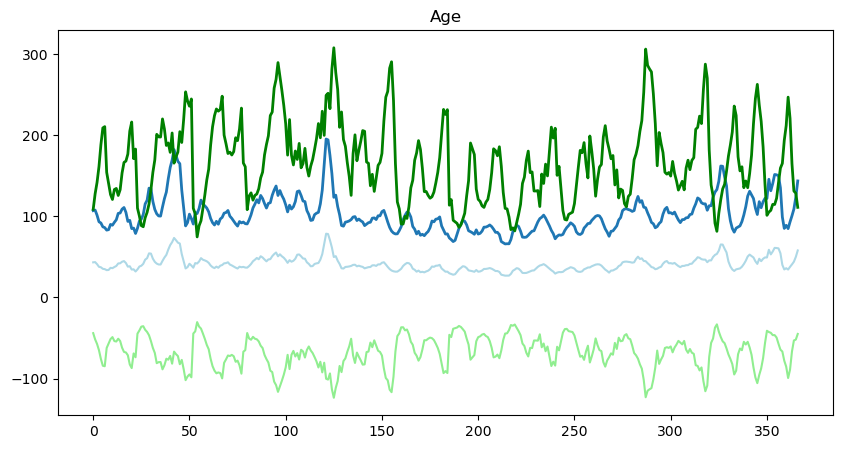

In [30]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][6]] #Base moves line up and down
shift2= [-0.5-0.4*age for age in age_2018['backrosVS_jan18'][6]]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(age_2018['for_jan18'][6],lw=2)
ax.plot(age_2018['backrosVS_jan18'][6],color='g',lw=2)
ax.plot(shift,color='lightblue')
ax.plot(shift2,color='lightgreen')
ax.set_title('Age')

### Correlation with density difference and tides - Haro

0.8233476382140206


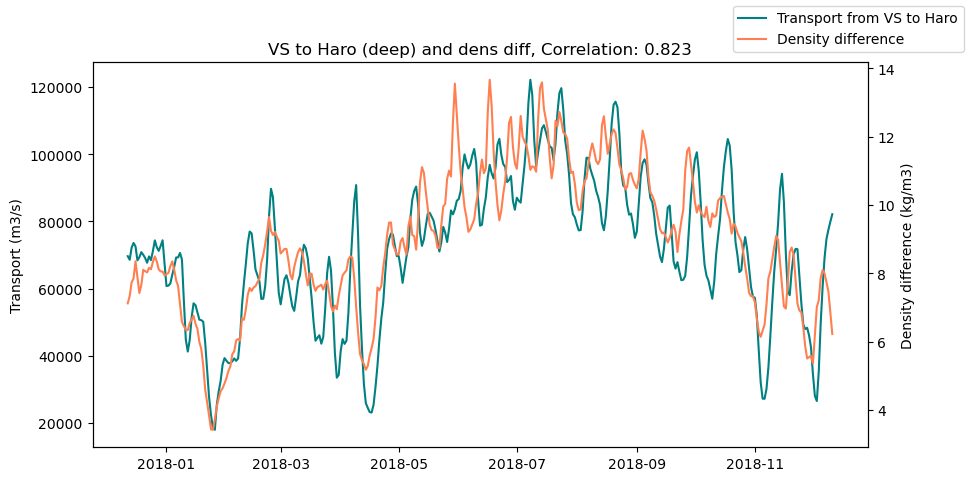

In [31]:
dateharo_sh = list(VStoHaro_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_vs = dens_diff[mask]

datelist_VStoHaro_dens = np.array(datelist_dens)[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoHaro_avg.dropna(),label='Transport from VS to Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(datelist_VStoHaro_dens,densdiff_vs,color='coral',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

corr_VStoHaro_dens,pvalue = stats.spearmanr(VStoHaro_avg.dropna(),densdiff_vs)
ax.set_title(f'VS to Haro (deep) and dens diff, Correlation: {np.round(corr_VStoHaro_dens,3)}')
print(corr_VStoHaro_dens)

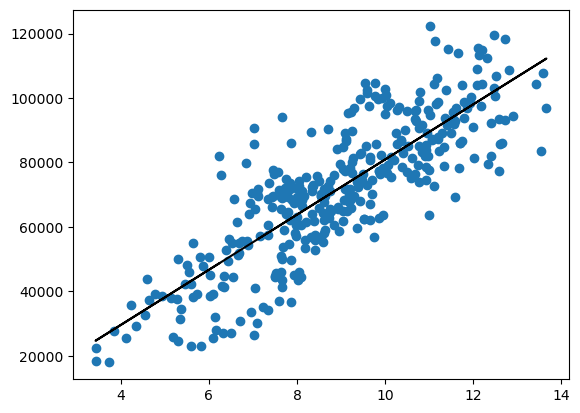

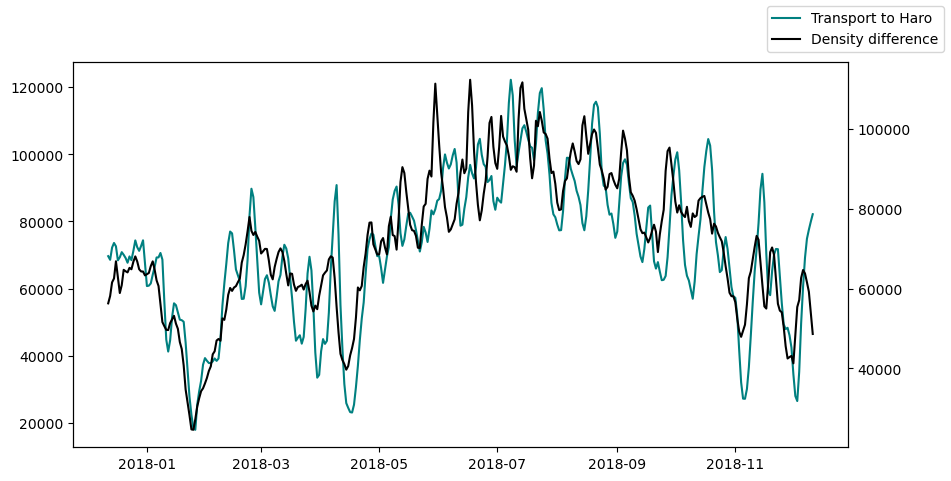

In [32]:
slope,intercept = np.polyfit(densdiff_vs,VStoHaro_avg.dropna(),1)
ddline_haro = slope*densdiff_vs+intercept
res_haro = VStoHaro_avg.dropna()-ddline_haro

plt.scatter(densdiff_vs,VStoHaro_avg.dropna())
plt.plot(densdiff_vs,ddline_haro,color='k')
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(VStoHaro_avg.dropna(),color='teal',label='Transport to Haro')
ax2=ax.twinx()
ax2.plot(dateharo_sh,ddline_haro,color='k',label='Density difference')
fig.legend()

In [33]:
intercept

-4659.926516138696

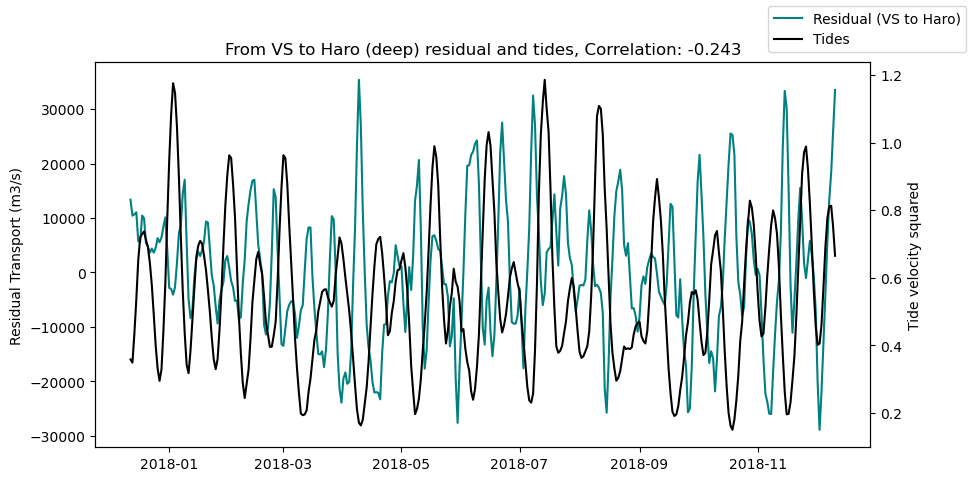

In [34]:
mask2 = np.isin(datelist_tides,dateharo_sh)

tides_vs = tides.vozocrtx[mask2]

corr_VStoHarod_tides,pvalue = stats.spearmanr(tides_vs,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual (VS to Haro)')
ax2=ax.twinx()
ax2.plot(dateharo_sh,tides_vs,color='k',label='Tides')
ax.set_title(f'From VS to Haro (deep) residual and tides, Correlation: {np.round(corr_VStoHarod_tides,3)}')
ax.set_ylabel('Residual Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

Look at if there is a different correlation in winter vs. summer

Text(0.5, 1.0, 'Correlation: -0.5251458738538484')

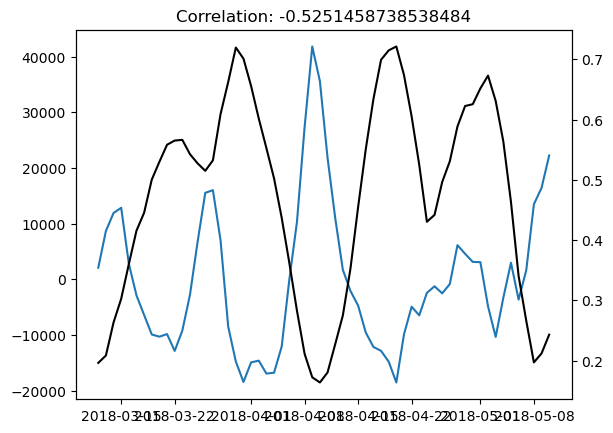

In [35]:
idx1 = 90
idx2 = 150

slope,intercept = np.polyfit(densdiff_vs[idx1:idx2],VStoHaro_avg.dropna()[idx1:idx2],1)
ddline_haro_wint = slope*densdiff_vs[idx1:idx2]+intercept
res_haro_wint = VStoHaro_avg.dropna()[idx1:idx2]-ddline_haro_wint

dateharo_shw = list(VStoHaro_avg.dropna()[idx1:idx2].index)

mask = np.isin(datelist_tides,dateharo_shw)
tides_vs_wint = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_vs_wint,VStoHaro_avg.dropna()[idx1:idx2])

fig,ax = plt.subplots()

ax.plot(res_haro_wint)
ax2=ax.twinx()
ax2.plot(dateharo_shw,tides_vs_wint,color='k')
ax.set_title(f'Correlation: {corr}')

Different correlations at different times of the year

### Correlation with tides and density difference - Rosario

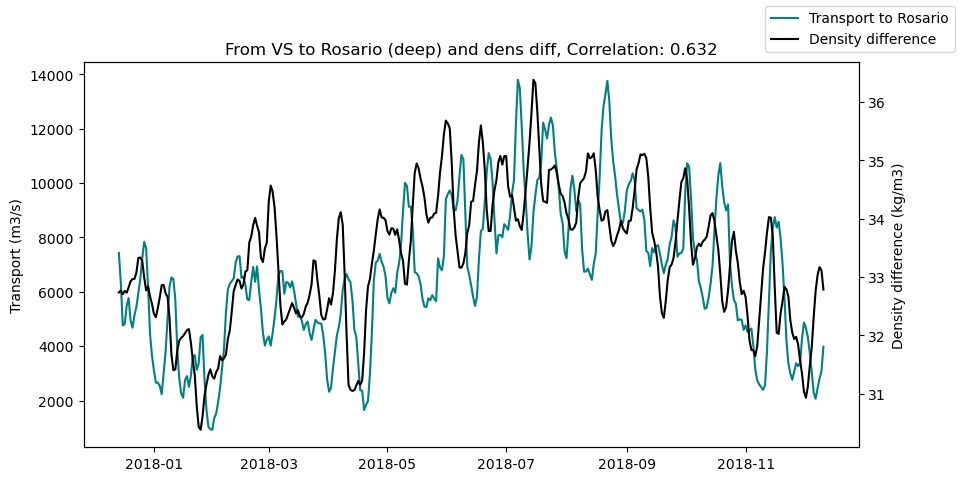

In [36]:
daterosd_sh = list(VStoRos_avg.dropna().index)
VStoRos_avgd = VStoRos_avg.dropna()

mask = np.isin(datelist_dens,daterosd_sh)
densdiff_ros = dens_diff_ros[mask]

corr_VStoRos_dens,p = stats.spearmanr(densdiff_ros,VStoRos_avgd)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(VStoRos_avgd,'teal',label='Transport to Rosario')
ax2=ax.twinx()
ax2.plot(daterosd_sh,densdiff_ros,color='k',label='Density difference')
ax.set_title(f'From VS to Rosario (deep) and dens diff, Correlation: {np.round(corr_VStoRos_dens,3)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

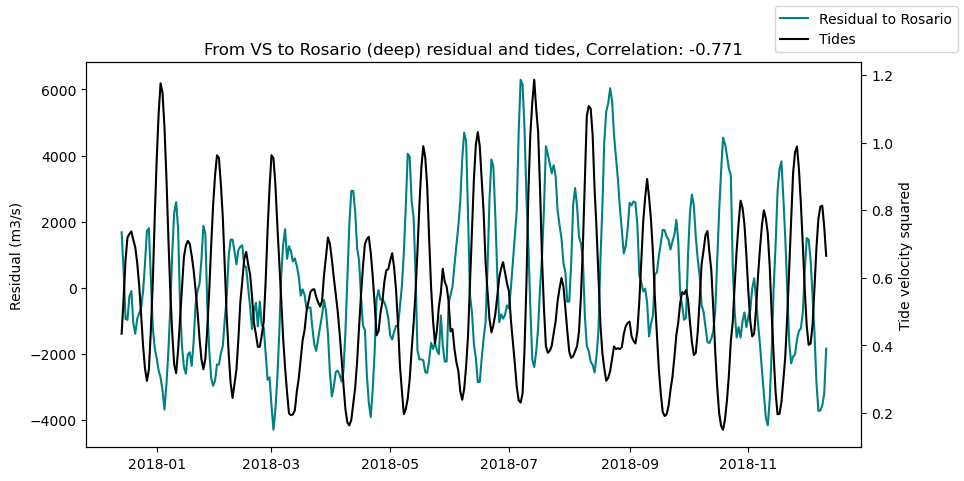

In [37]:
slope ,intercept = np.polyfit(densdiff_ros,VStoRos_avgd,1)
ddline_ros = slope*densdiff_ros+intercept
res_ros = VStoRos_avgd - ddline_ros

mask = np.isin(datelist_tides,daterosd_sh)
tides_ros = tides.vozocrtx[mask]

corr_VStoRos_tides,p = stats.spearmanr(tides_ros,res_ros)

fig,ax = plt.subplots(figsize=(10,5))
    
ax.plot(res_ros,'teal',label='Residual to Rosario')
ax2=ax.twinx()
ax2.plot(daterosd_sh,tides_ros,color='k',label='Tides')
ax.set_title(f'From VS to Rosario (deep) residual and tides, Correlation: {np.round(corr_VStoRos_tides,3)}')
ax2.set_ylabel('Tide velocity squared')
ax.set_ylabel('Residual (m3/s)')
fig.legend()

In [38]:
corr,p = stats.spearmanr(tides_ros,VStoRos_avgd)
corr

-0.472106748098712

### Surface waters (from Haro to VS)

In [39]:
HarotoVSbl = sectransp_2018['backVS_jan18'][6]
HarotoVSl = sectransp_2018['forharoVS_jan18'][6]

HarotoVS = pd.Series(HarotoVSl,index=datelist_vs)
HarotoVSb = pd.Series(HarotoVSbl,index=datelist_vs)

In [40]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.52:
            print (base, factor, corr_arr[i, j])

-1.0 0.40000000000000124 0.5218187484100989
-0.95 0.30000000000000115 0.521620017353728
-0.7999999999999998 0.2500000000000011 0.5203414531733624
-0.7499999999999998 0.30000000000000115 0.5218187484100989
-0.6499999999999997 0.20000000000000107 0.5215139615836838
-0.49999999999999956 0.20000000000000107 0.5218187484100989
-0.24999999999999933 0.10000000000000098 0.5218187484100989


In [41]:
i_base_haros,i_factor_haros = np.where(corr_arr==np.max(corr_arr))

base_haros = base_arr[i_base_haros]
factor_haros = factor_arr[i_factor_haros]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[-0.3  -0.15] [-0.9  -0.95]


0.4802146631319053


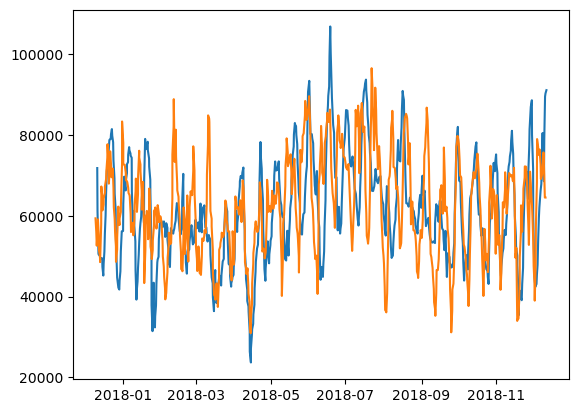

In [42]:
HarotoVS_sh = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base_arr[i_base_haro][0],factor_haros[0])
HarotoVSb_sh = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base_arr[i_base_haro][0],-factor_haros[0])

HarotoVS_m,HarotoVSb_m,c,HarotoVS_avg = merge(HarotoVS_sh,HarotoVSb_sh)
print(c)

plt.plot(HarotoVS_m.Transport)
plt.plot(HarotoVSb_m.Transport)

Text(0.5, 0, 'Base')

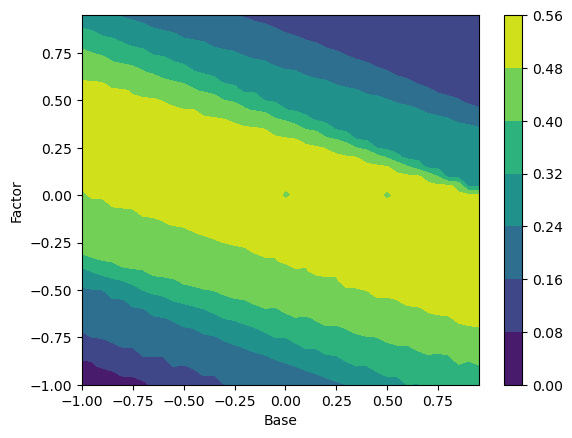

In [43]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

Text(0.5, 1.0, 'Haro to VS (surface) and density difference, Correlation: 0.446')

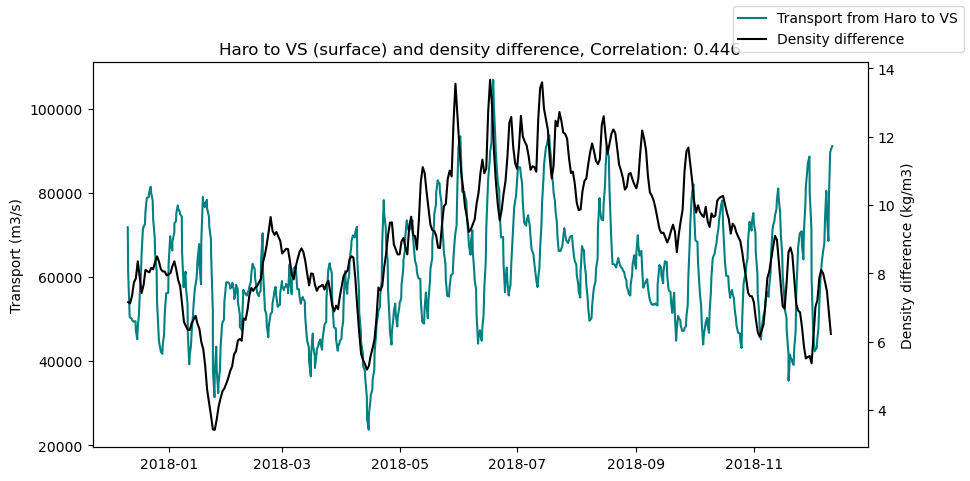

In [44]:
dateharos_sh = list(HarotoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateharos_sh)
densdiff_haro = dens_diff[mask]
date_HarotoVS_dens = np.array(datelist_dens)[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_m.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(date_HarotoVS_dens,densdiff_haro,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

corr_HarotoVS_dens,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),densdiff_haro)
ax.set_title(f'Haro to VS (surface) and density difference, Correlation: {np.round(corr_HarotoVS_dens,3)}')

0.44578843763901627


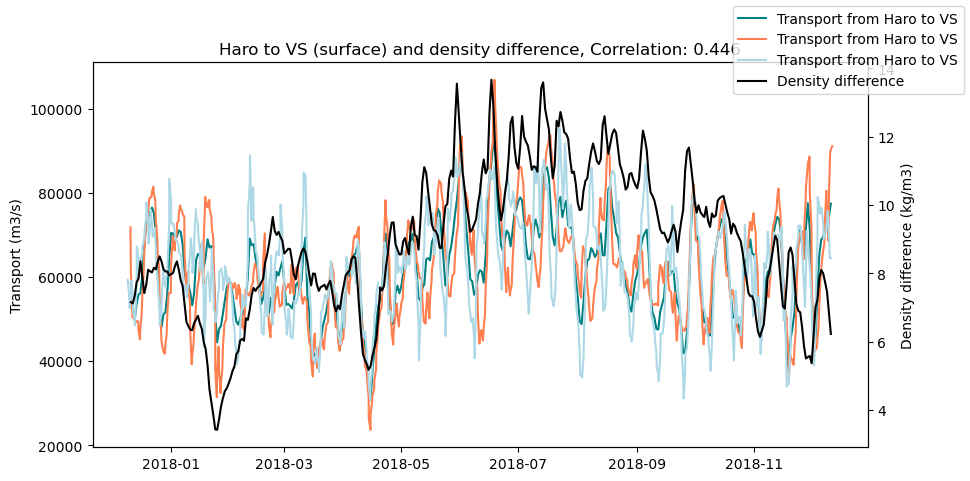

In [45]:
dateharos_sh = list(HarotoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateharos_sh)
densdiff_haro = dens_diff[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax.plot(HarotoVS_m.dropna(),label='Transport from Haro to VS',color='coral')
ax.plot(HarotoVSb_m.dropna(),label='Transport from Haro to VS',color='lightblue')
ax2 = ax.twinx()
ax2.plot(date_HarotoVS_dens,densdiff_haro,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),densdiff_haro)
ax.set_title(f'Haro to VS (surface) and density difference, Correlation: {np.round(correlation,3)}')
print(correlation)

0.44578843763901627


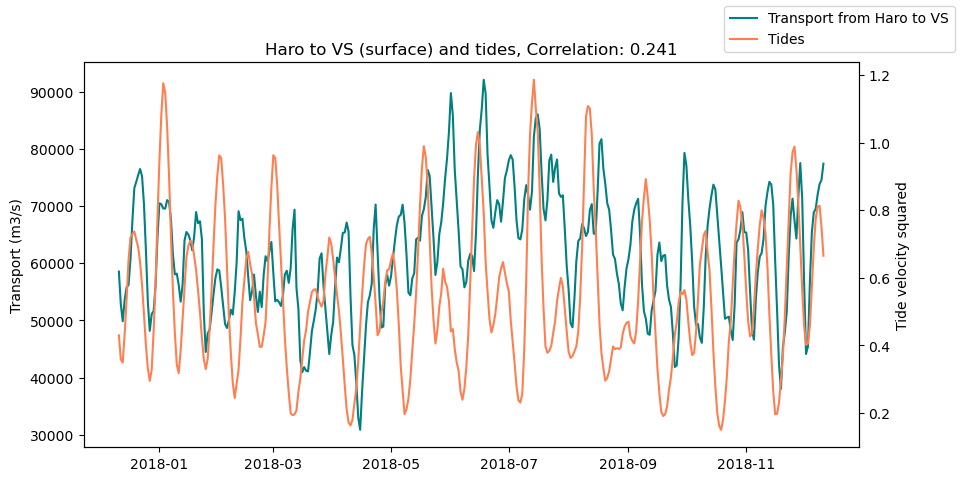

In [46]:
mask = np.isin(datelist_tides,dateharos_sh)
tides_haro = tides.vozocrtx[mask]
date_HarotoVS_tides = np.array(datelist_tides)[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(date_HarotoVS_tides ,tides_haro,color='coral',label='Tides')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

corr_HarotoVS_tides,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),tides_haro)
ax.set_title(f'Haro to VS (surface) and tides, Correlation: {np.round(corr_HarotoVS_tides,3)}')
print(correlation)

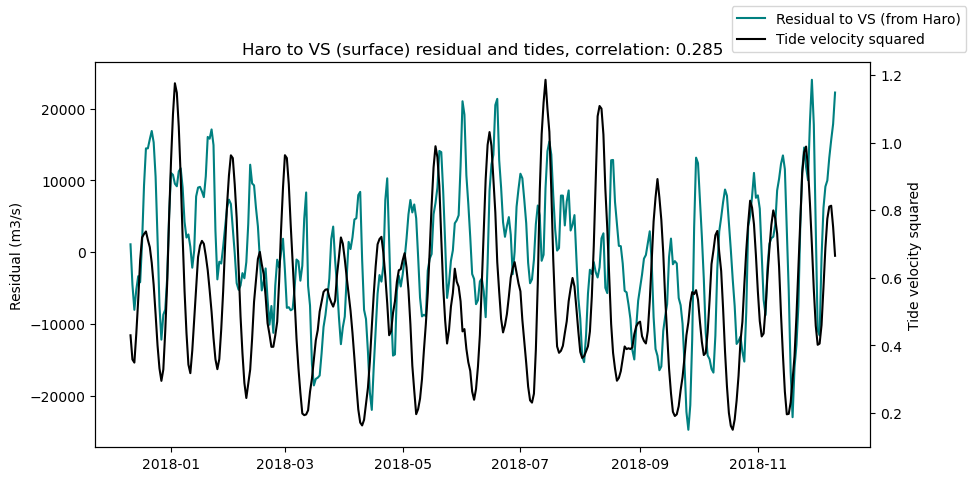

In [47]:
slope,intercept = np.polyfit(densdiff_haro,HarotoVS_avg.dropna(),1)

ddline_haro = slope*densdiff_haro+intercept
res_haro = HarotoVS_avg.dropna() - ddline_haro

corr_HarotoVS_tides,p = stats.spearmanr(tides_haro,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,'teal',label='Residual to VS (from Haro)')
ax2=ax.twinx()
ax2.plot(date_HarotoVS_tides,tides_haro,color='k',label='Tide velocity squared')
ax.set_title(f'Haro to VS (surface) residual and tides, correlation: {np.round(corr_HarotoVS_tides,3)}')
ax.set_ylabel('Residual (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()


-0.027657563005927484


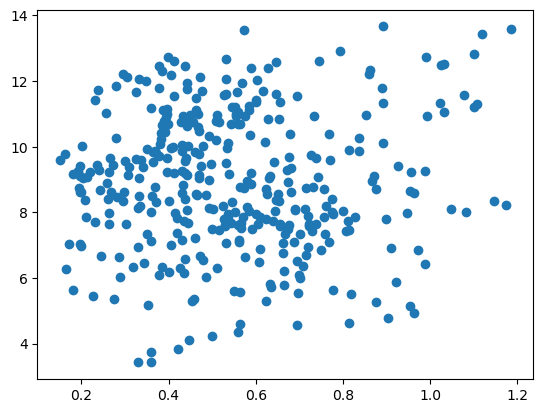

In [48]:
# Look at correlation between tides and density difference
corr,p = stats.spearmanr(tides_haro,densdiff_haro)
print(corr)
plt.scatter(tides_haro,densdiff_haro)

In [49]:
corr,p = stats.spearmanr(tides_haro,HarotoVS_avg.dropna())
corr

0.24142301274406439

Surface transport positively correlated with tides????

**Next steps:** 
- Look at correlation with baroclinic velocity 
- Look at surface flow in Rosario and see if that's also positive

### Baroclinic velocity - Haro/VS

Calculate baroclinic after shift (surface and deep waters are on the correct day)

Text(0, 0.5, 'Density difference (kg/m3)')

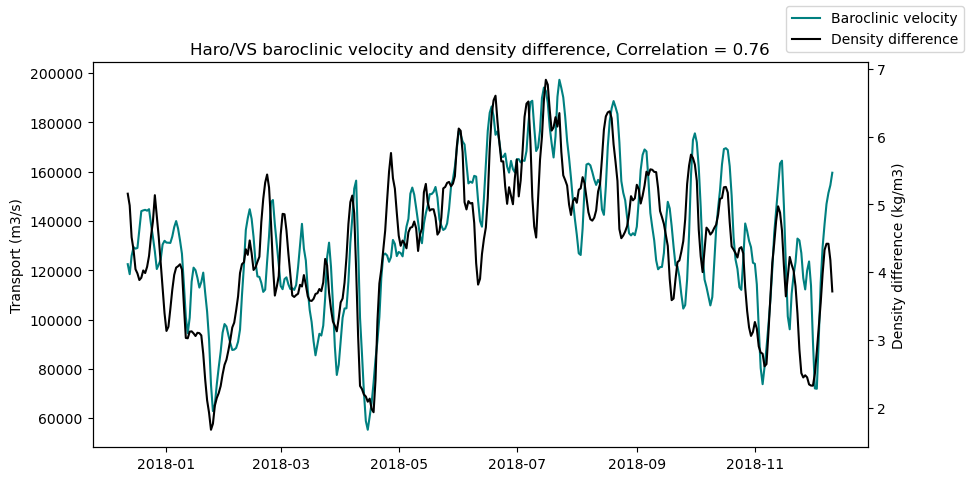

In [50]:
HaroVS_bclin = (VStoHaro_avg.dropna()+HarotoVS_avg.dropna()).dropna()

dateharo_bclin = list(HaroVS_bclin.index)

mask = np.isin(datelist_dens,dateharo_bclin)
densdiff_haro_bclin = np.array(dens_diff_haro)[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin,HaroVS_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HaroVS_bclin,label='Baroclinic velocity',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro_bclin,color='k',label='Density difference')
ax.set_title(f'Haro/VS baroclinic velocity and density difference, Correlation = {np.round(corr,2)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')

Correlation is higher than when looking at surface but lower than when just looking at deep (.82)

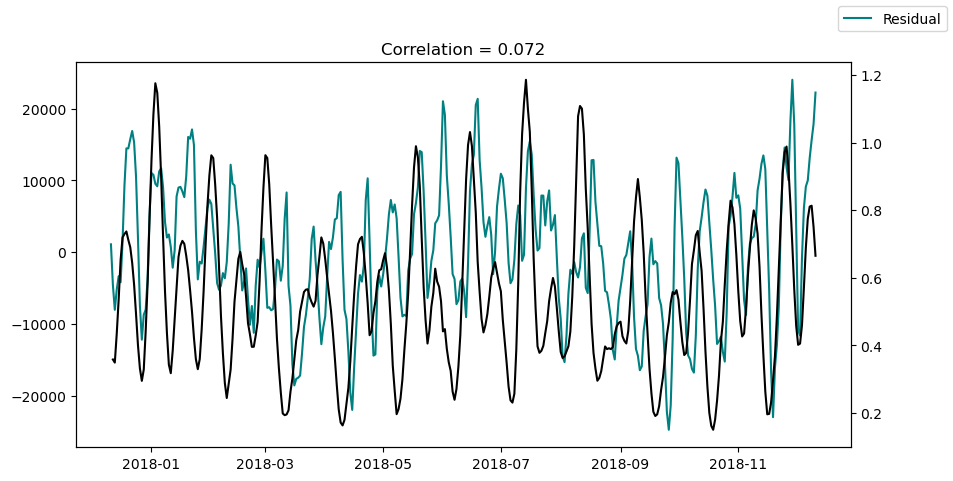

In [51]:
slope,intercept = np.polyfit(densdiff_haro_bclin,HaroVS_bclin,1)
haroVS_line = slope*densdiff_haro_bclin+intercept
res_haroVS = HaroVS_bclin-haroVS_line

mask = np.isin(datelist_tides,dateharo_bclin)
tides_harosh = tides.vozocrtx[mask]

corr,intercept = stats.spearmanr(tides_harosh,res_haroVS)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual')
ax2=ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_harosh,color='k')
ax.set_title(f'Correlation = {np.round(corr,3)}')
fig.legend()


Residual from baroclinic velocity not as highly correlated as individual surface and deep waters (positive correlation in surface and negative correlation in deep)

### Surface Waters - Rosario

In [52]:
RostoVSl = sectransp_2018['forrosVS_jan18'][4]
RostoVSbl = sectransp_2018['backVS_jan18'][4]

RostoVS = pd.Series(RostoVSl,index=datelist_vs)
RostoVSb = pd.Series(RostoVSbl,index=datelist_vs)

In [53]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(RostoVS,age_2018['forrosVS_jan18'][4],datelist_vs,base,factor)
        dfr2 = shift_time(RostoVSb,age_2018['backVS_jan18'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.91:
            print (base, factor, corr_arr[i, j])

0.0 0.45 0.9149222480960508
0.0 0.5 0.9223153700464699
0.0 0.55 0.913121000875319
0.05 0.45 0.9191607329308228
0.05 0.5 0.9179606451719851
0.05 0.55 0.9112384107876652
0.1 0.45 0.9227275950053485
0.1 0.5 0.9161103929535376
0.1 0.55 0.9104171927746942
0.15000000000000002 0.45 0.9243065599258767
0.15000000000000002 0.5 0.9148052819844203
0.2 0.4 0.9114403769702251
0.2 0.45 0.9228435017659288
0.2 0.5 0.9153694618969608
0.25 0.4 0.9173061500807439
0.25 0.45 0.916545367811735
0.25 0.5 0.9115637600410151
0.30000000000000004 0.4 0.9207118619057966
0.30000000000000004 0.45 0.916690587055445
0.30000000000000004 0.5 0.9120392620032106
0.35000000000000003 0.4 0.9214598842443892
0.35000000000000003 0.45 0.9162029160944029
0.35000000000000003 0.5 0.9109627624717005
0.4 0.4 0.9203467542285002
0.4 0.45 0.9165775770134847
0.45 0.35000000000000003 0.9101479832449191
0.45 0.4 0.9146823747424843
0.45 0.45 0.9171001250035689
0.5 0.35000000000000003 0.9160331151952719
0.5 0.4 0.9174678586481124
0.5 0.45 0.

[0.15] [0.45]


Text(0.5, 0, 'Base')

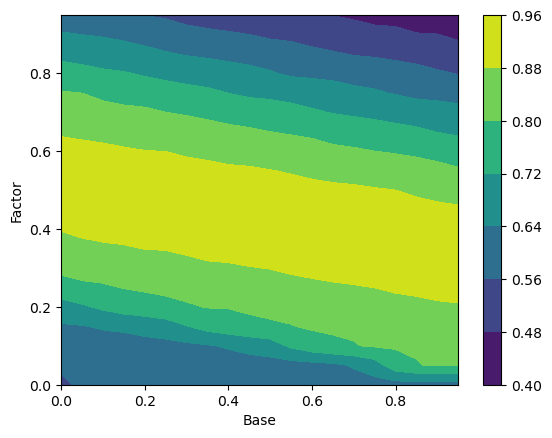

In [54]:
i_base_ross,i_factor_ross = np.where(corr_arr==np.max(corr_arr))

base_ross = base_arr[i_base_ross]
factor_ross = factor_arr[i_factor_ross]

print(base_arr[i_base_ross],factor_arr[i_factor_ross])

x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

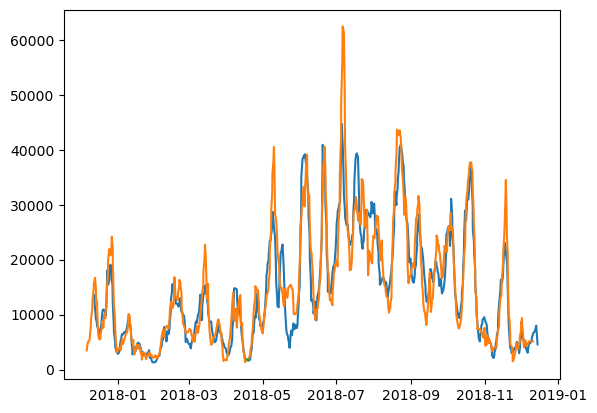

In [55]:
RostoVS_sh = shift_time(RostoVS,age_2018['forrosVS_jan18'][4],datelist_vs,base_arr[i_base_ross][0],factor_ross[0])
RostoVS_bsh = shift_time(RostoVSb,age_2018['backVS_jan18'][4],datelist_vs,-base_ross[0],-factor_ross[0])

RostoVS_m,RostoVSb_m,c,RostoVS_avg = merge(RostoVS_sh,RostoVS_bsh)

plt.plot(RostoVS_m)
plt.plot(RostoVSb_m)
plt.plot(RostoVS_avg)

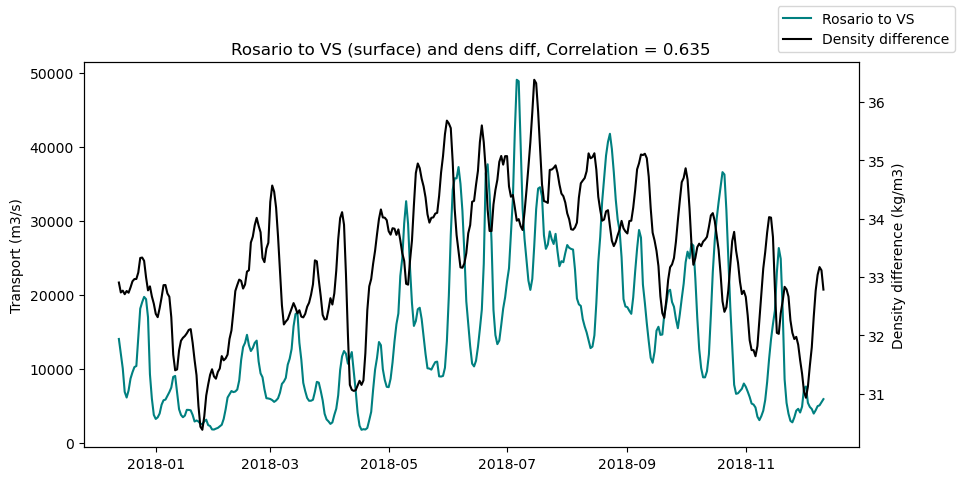

In [56]:
dateros_surf = list(RostoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateros_surf)
densdiff_ros_surf = dens_diff_ros[mask]
date_RostoVS_dens = np.array(datelist_dens)[mask]

corr_RostoVS_dens,p = stats.spearmanr(densdiff_ros_surf,RostoVS_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(RostoVS_avg.dropna(),color='teal',label='Rosario to VS')
ax2 = ax.twinx()
ax2.plot(date_RostoVS_dens,densdiff_ros_surf,color='k',label='Density difference')
ax.set_title(f'Rosario to VS (surface) and dens diff, Correlation = {np.round(corr_RostoVS_dens,3)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()


Text(0, 0.5, 'Density difference ')

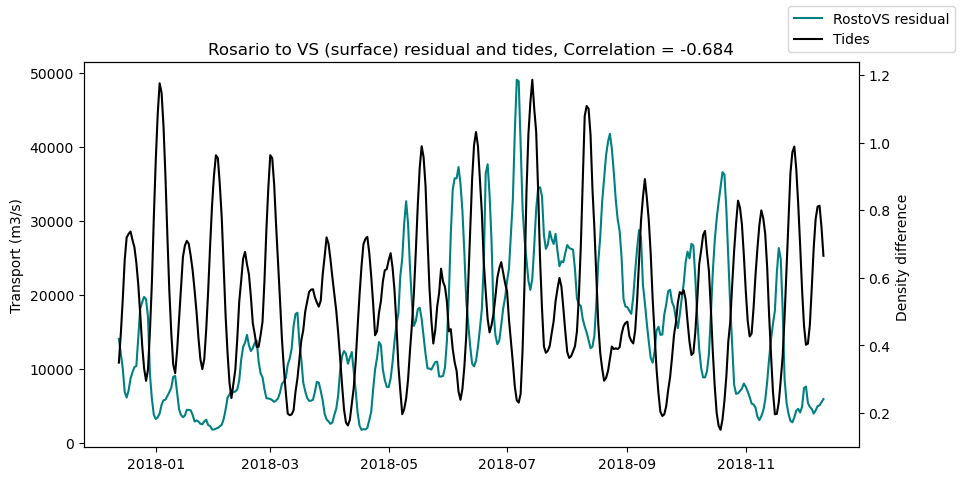

In [57]:
slope,intercept = np.polyfit(densdiff_ros_surf,RostoVS_avg.dropna(),1)

ddline_ross = slope*densdiff_ros_surf+intercept
res_ross = RostoVS_avg.dropna()-ddline_ross

mask = np.isin(datelist_tides,dateros_surf)
tidesros_surf = tides.vozocrtx[mask]

date_RostoVS_tides = np.array(datelist_tides)[mask]

corr_RostoVS_tides,p = stats.spearmanr(tidesros_surf,res_ross)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(RostoVS_avg.dropna(),color='teal',label='RostoVS residual')
ax2=ax.twinx()
ax2.plot(date_RostoVS_tides,tidesros_surf,color='k',label='Tides')
ax.set_title(f'Rosario to VS (surface) residual and tides, Correlation = {np.round(corr_RostoVS_tides,3)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference ')

Correlation with tides

In [58]:
corr,p = stats.spearmanr(tidesros_surf,RostoVS_avg.dropna())
print(corr)

-0.45435212359247223


In [59]:
corr,p = stats.spearmanr(tides_ros,VStoRos_avg.dropna())
corr

-0.472106748098712

Look at baroclinic

0.6377091015463693


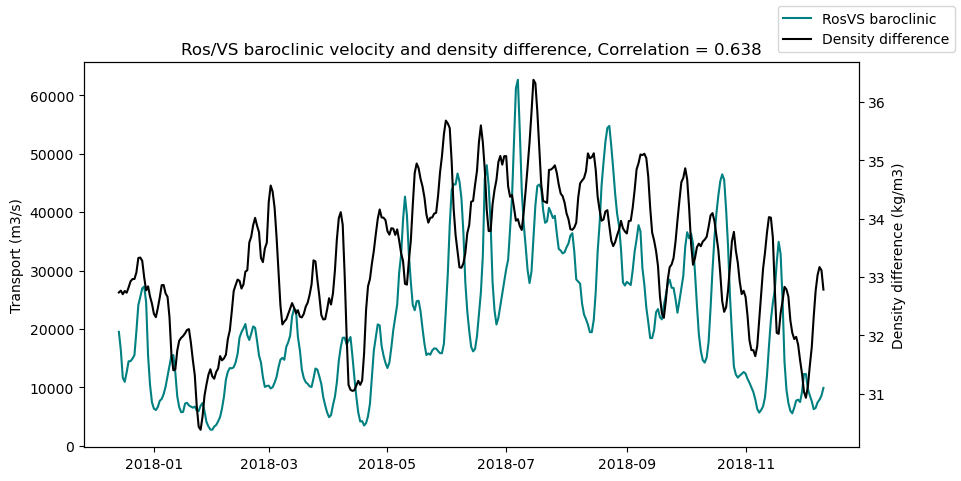

In [60]:
RosVS_bclin = (VStoRos_avg.dropna() + RostoVS_avg.dropna()).dropna()

date_rosVS = list(RosVS_bclin.index)

mask = np.isin(datelist_dens,date_rosVS)
densdiff_ros_bclin = dens_diff_ros[mask]

corr,p = stats.spearmanr(densdiff_ros_bclin,RosVS_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(RosVS_bclin,color='teal',label='RosVS baroclinic')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_ros_bclin,color='k',label='Density difference')
ax.set_title(f'Ros/VS baroclinic velocity and density difference, Correlation = {np.round(corr,3)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')

print(corr)


Baroclinic essentially identical to just deep and just surface

#### Look at baroclinic

In [61]:
# First just plot tides (not residual)

corr,p =stats.spearmanr(tidesros_surf,RostoVS_avg.dropna())
print(corr)

mask = np.isin(datelist_tides,date_rosVS)
tidesros_btrp = tides.vozocrtx[mask]

RosVS_btrp = (VStoRos_avg.dropna() - RostoVS_avg.dropna())

corr,p = stats.spearmanr(tidesros_btrp,RosVS_btrp.dropna())
print(corr)

-0.45435212359247223
0.4017707556130459


Correlation with barotropic is positive but just surface/deep its negative?

**Next Steps**: 
- Look at if its different if you add them (for baroclinic) before shifting
- Look at longer time series (for meeting)

### San Juan Channel

### Deep

In [62]:
VStoSJCl = sectransp_2018['for_jan18'][5]
VStoSJCbl = sectransp_2018['backsjcVS_jan18'][5]

VStoSJC = pd.Series(VStoSJCl,index=datelist_vs)
VStoSJCb = pd.Series(VStoSJCbl,index=datelist_vs)

In [63]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoSJC,age_2018['for_jan18'][5],datelist_vs,base,factor)
        dfr2 = shift_time(VStoSJCb,age_2018['backsjcVS_jan18'][5],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

0.0 0.5 0.7343354917119406
0.1 0.5 0.7380624111156054
0.15000000000000002 0.5 0.7304955222816515
0.2 0.5 0.7323806252030939
0.25 0.45 0.7313652874566211
0.30000000000000004 0.45 0.7303190846784304
0.4 0.45 0.7383698948334547
0.5 0.45 0.7311471614504111
0.7000000000000001 0.4 0.7361745983678252


[0.4] [0.45]


Text(0.5, 0, 'Base')

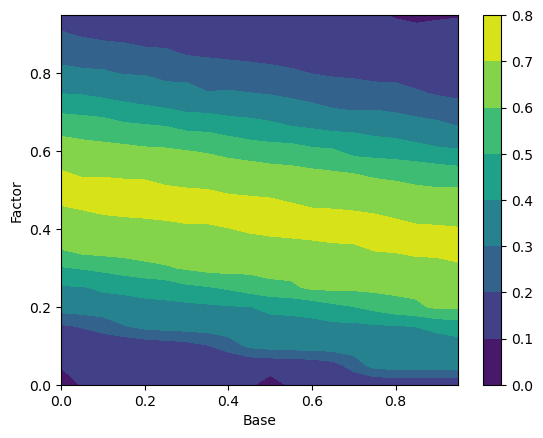

In [64]:
i_base_sjc,i_factor_sjc = np.where(corr_arr==np.max(corr_arr))

base_sjc = base_arr[i_base_sjc]
factor_sjc = factor_arr[i_factor_sjc]

print(base_arr[i_base_sjc],factor_arr[i_factor_sjc])

x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

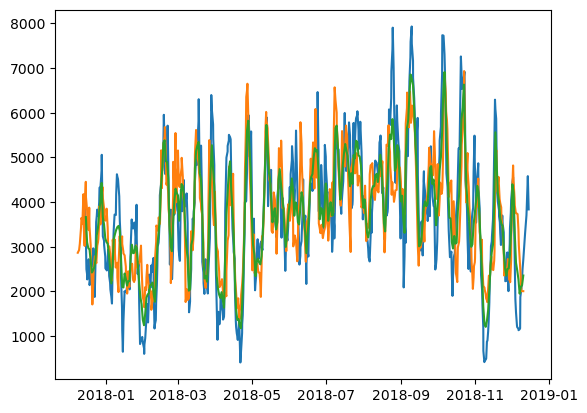

In [65]:
VStoSJC_sh = shift_time(VStoSJC,age_2018['for_jan18'][4],datelist_vs,base_arr[i_base_sjc][0],factor_sjc[0])
VStoSJC_bsh = shift_time(VStoSJCb,age_2018['backsjcVS_jan18'][4],datelist_vs,-base_sjc[0],-factor_sjc[0])

VStoSJC_m,VStoSJCb_m,c,VStoSJC_avg = merge(VStoSJC_sh,VStoSJC_bsh)

plt.plot(VStoSJC_m.dropna())
plt.plot(VStoSJCb_m.dropna())
plt.plot(VStoSJC_avg.dropna())

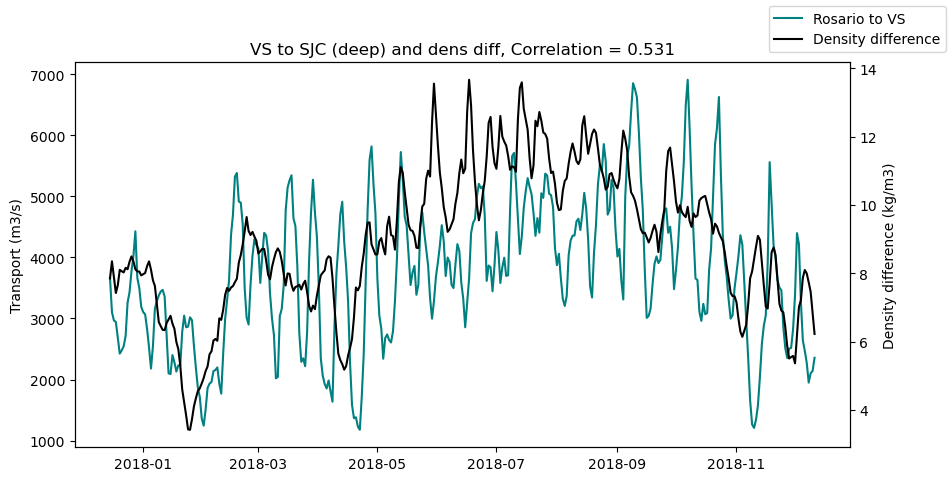

In [66]:
datesjc = list(VStoSJC_avg.dropna().index)
mask = np.isin(datelist_dens,datesjc)
densdiff_sjc = dens_diff[mask]

corr,p = stats.spearmanr(densdiff_sjc,VStoSJC_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoSJC_avg.dropna(),color='teal',label='Rosario to VS')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_sjc,color='k',label='Density difference')
ax.set_title(f'VS to SJC (deep) and dens diff, Correlation = {np.round(corr,3)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

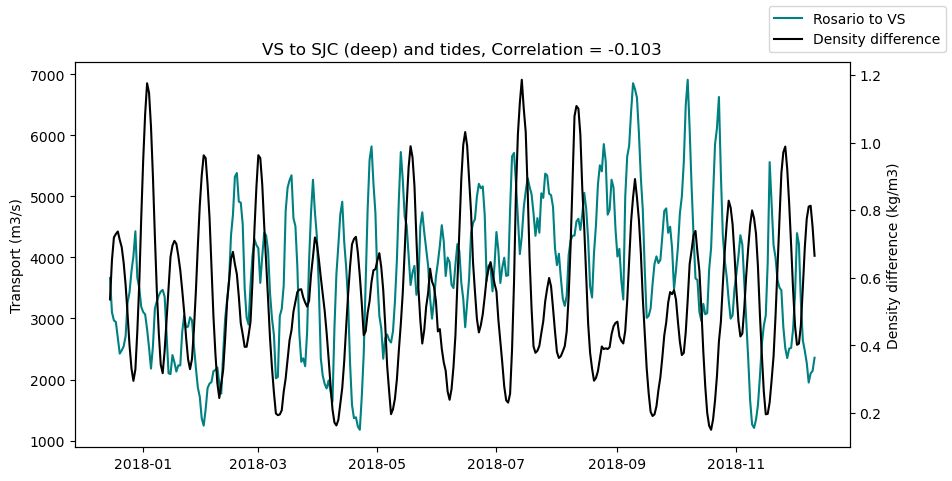

In [67]:
datesjc_tides = list(VStoSJC_avg.dropna().index)
mask = np.isin(datelist_tides,datesjc_tides)
tides_sjc = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sjc,VStoSJC_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoSJC_avg.dropna(),color='teal',label='Rosario to VS')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_sjc,color='k',label='Density difference')
ax.set_title(f'VS to SJC (deep) and tides, Correlation = {np.round(corr,3)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

In [68]:
VStoSJC_avg.dropna()

2017-12-15    3664.338219
2017-12-16    3102.717847
2017-12-17    2967.555904
2017-12-18    2942.320901
2017-12-19    2687.052667
                 ...     
2018-12-07    2272.557197
2018-12-08    1949.926843
2018-12-09    2100.925707
2018-12-10    2140.645527
2018-12-11    2356.418694
Name: Transport, Length: 362, dtype: float64

Text(0, 0.5, 'Density difference ')

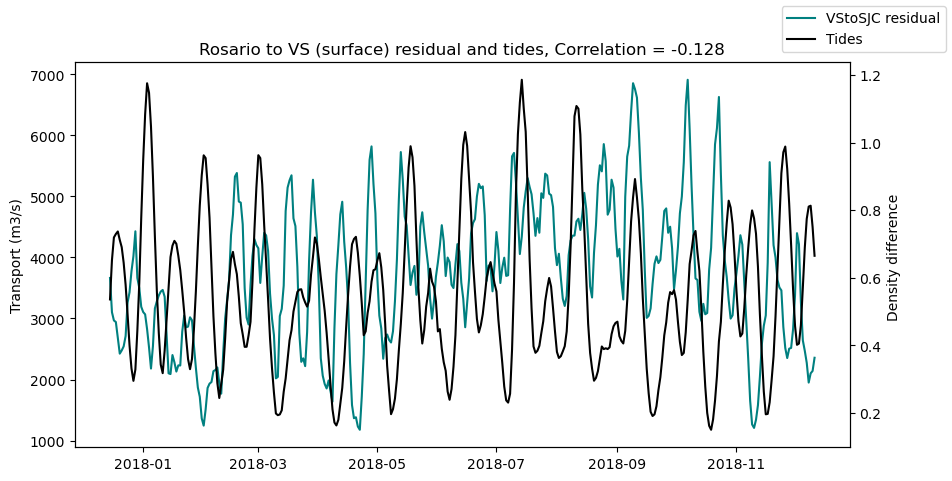

In [69]:
slope,intercept = np.polyfit(densdiff_sjc,VStoSJC_avg.dropna(),1)

ddline_sjc = slope*densdiff_sjc+intercept
res_sjc = VStoSJC_avg.dropna()-ddline_sjc

mask = np.isin(datelist_tides,datesjc)
tides_sjc = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sjc,res_sjc)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoSJC_avg.dropna(),color='teal',label='VStoSJC residual')
ax2=ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_sjc,color='k',label='Tides')
ax.set_title(f'Rosario to VS (surface) residual and tides, Correlation = {np.round(corr,3)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference ')

#### Look at the surface

In [70]:
SJCtoVSl = sectransp_2018['forsjcVS_jan18'][5]
SJCtoVSbl = sectransp_2018['backVS_jan18'][5]

SJCtoVS = pd.Series(SJCtoVSl,index=datelist_vs)
SJCtoVSb = pd.Series(SJCtoVSbl,index=datelist_vs)

In [71]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(SJCtoVS,age_2018['forsjcVS_jan18'][5],datelist_vs,base,factor)
        dfr2 = shift_time(SJCtoVSb,age_2018['backVS_jan18'][5],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.85:
            print (base, factor, corr_arr[i, j])

0.0 0.45 0.8540934581948922
0.0 0.5 0.8551021474518383
0.0 0.55 0.8535694463690203
0.05 0.45 0.8570419650049277
0.05 0.5 0.8549618593461327
0.05 0.55 0.8530285933414709
0.1 0.45 0.8575269459631021
0.1 0.5 0.8540206922622281
0.15000000000000002 0.4 0.8520686826887857
0.15000000000000002 0.45 0.8556178155458958
0.15000000000000002 0.5 0.8573106470302843
0.2 0.4 0.8572966996456687
0.2 0.45 0.854506960265767
0.2 0.5 0.8585130945195684
0.25 0.4 0.8571453283919146
0.25 0.45 0.8541934572368004
0.25 0.5 0.8535624885166181
0.30000000000000004 0.4 0.8587515257511779
0.30000000000000004 0.45 0.8589857286373958
0.35000000000000003 0.4 0.8585765951780217
0.35000000000000003 0.45 0.8577105162040431
0.4 0.35000000000000003 0.856405746294904
0.4 0.4 0.856000323135243
0.4 0.45 0.8598011815138618
0.45 0.35000000000000003 0.8564275662026677
0.45 0.4 0.8533571450554822
0.45 0.45 0.8548256746304459
0.5 0.35000000000000003 0.8570301648162252
0.5 0.4 0.8579933709929923
0.55 0.35000000000000003 0.859276488505

[0.7] [0.35]


Text(0.5, 0, 'Base')

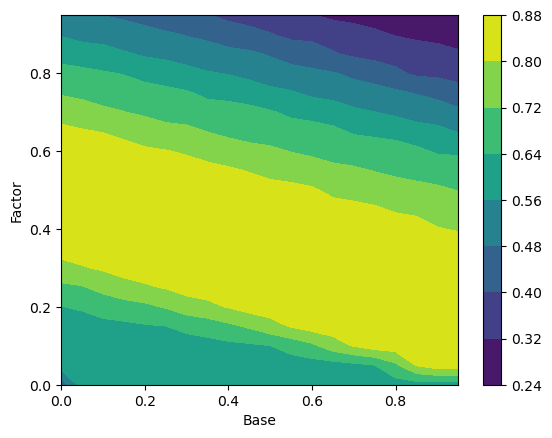

In [72]:
i_base_sjc,i_factor_sjc = np.where(corr_arr==np.max(corr_arr))

base_sjc = base_arr[i_base_sjc]
factor_sjc = factor_arr[i_factor_sjc]

print(base_arr[i_base_sjc],factor_arr[i_factor_sjc])

x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

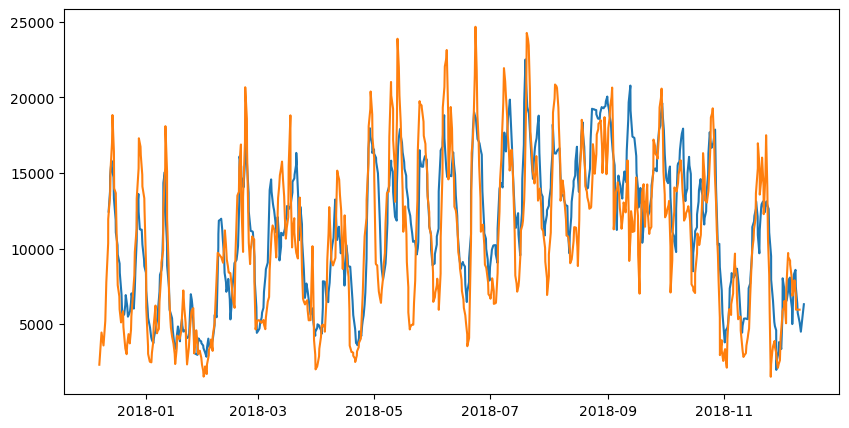

In [73]:
SJCtoVS_sh = shift_time(SJCtoVS,age_2018['forsjcVS_jan18'][5],datelist_vs,base_arr[i_base_sjc][0],factor_sjc[0])
SJCtoVS_bsh = shift_time(SJCtoVSb,age_2018['backVS_jan18'][5],datelist_vs,-base_sjc[0],-factor_sjc[0])

SJCtoVS_m,SJCtoVSb_m,c,SJCtoVS_avg = merge(SJCtoVS_sh,SJCtoVS_bsh)
plt.subplots(figsize=(10,5))
plt.plot(SJCtoVS_m.dropna())
plt.plot(SJCtoVSb_m.dropna())
# plt.plot(SJCtoVS_avg.dropna())

In [74]:
datesjc_surf = list(SJCtoVS_avg.dropna().index)

mask = np.isin(datelist_dens,datesjc_surf)
densdiff_sjcs = dens_diff[mask]
mask2 = np.isin(datesjc_surf,datelist_dens)

corr_SJCtoVS,p = stats.spearmanr(densdiff_sjcs,SJCtoVS_avg.dropna())
print(corr_SJCtoVS)

0.5999370492521177


In [75]:
slope,intercept = np.polyfit(densdiff_sjcs,SJCtoVS_avg.dropna(),1)
ddline = slope*densdiff_sjcs+intercept
res_sjcs = SJCtoVS_avg.dropna() - ddline

mask = np.isin(datelist_tides,datesjc_surf)
SJCtoVS_tides = tides.vozocrtx[mask]

corr_SJCtoVS_tides,p =stats.spearmanr(SJCtoVS_tides,SJCtoVS_avg.dropna())
corr_SJCtoVS_tides

-0.3000919379499703

### Combined Figures

#### Haro Strait

/tmp/ipykernel_31844/1786335788.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,14,2),color=color2)
/tmp/ipykernel_31844/1786335788.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(20000,120000,20000),color=color1)
/tmp/ipykernel_31844/1786335788.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22.set_yticklabels(np.arange(0.2,1.2,0.1),color=color4)
/tmp/ipykernel_31844/1786335788.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(-20000,20000,20000),color=color3)
/tmp/ipykernel_31844/1786335788.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(20000,120000,20000),color=color1)
/tmp/ipykernel_31844/1786335788.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  a

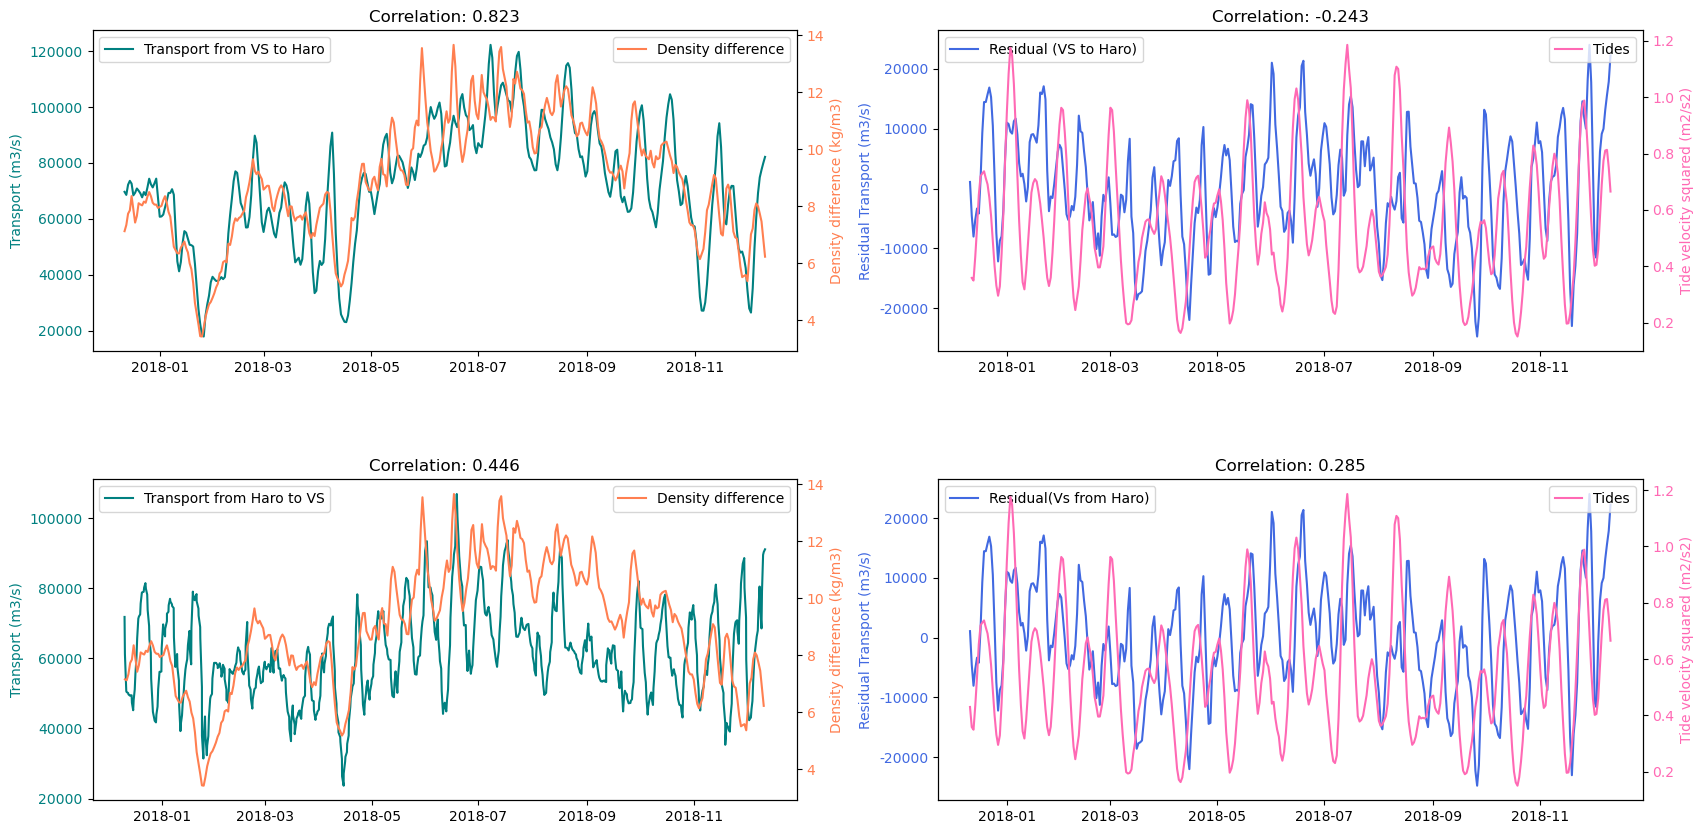

In [76]:
color1 = 'teal'
color2 = 'coral'
color3 = 'royalblue'
color4 = 'hotpink'

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(20,10))

ax1.plot(VStoHaro_avg.dropna(),label='Transport from VS to Haro',color=color1)
ax12 = ax1.twinx()
ax12.plot(datelist_VStoHaro_dens,densdiff_vs,color=color2,label='Density difference')
ax1.set_ylabel('Transport (m3/s)',color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax1.legend(loc=2)
ax12.legend()
ax1.set_title(f'Correlation: {np.round(corr_VStoHaro_dens,3)}')
ax12.set_yticklabels(np.arange(4,14,2),color=color2)
ax12.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax1.set_yticklabels(np.arange(20000,120000,20000),color=color1)
ax1.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax2.plot(res_haro,color=color3,label='Residual (VS to Haro)')
ax22=ax2.twinx()
ax22.plot(dateharo_sh,tides_vs,color=color4,label='Tides')
ax2.set_title(f'Correlation: {np.round(corr_VStoHarod_tides,3)}')
ax2.set_ylabel('Residual Transport (m3/s)',color=color3)
ax22.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax22.set_yticklabels(np.arange(0.2,1.2,0.1),color=color4)
ax22.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax2.set_yticklabels(np.arange(-20000,20000,20000),color=color3)
ax2.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax2.legend(loc=2)
ax22.legend()

ax3.plot(HarotoVS_m.dropna(),label='Transport from Haro to VS',color=color1)
ax32 = ax3.twinx()
ax32.plot(date_HarotoVS_dens,densdiff_haro,color=color2,label='Density difference')
ax3.set_ylabel('Transport (m3/s)',color=color1)
ax32.set_ylabel('Density difference (kg/m3)',color=color2)
ax3.legend(loc=2)
ax32.legend()
ax3.set_title(f'Correlation: {np.round(corr_HarotoVS_dens,3)}')
ax3.set_yticklabels(np.arange(20000,120000,20000),color=color1)
ax3.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax32.set_yticklabels(np.arange(5,12.5,2.5),color=color2)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax4.plot(res_haro,color3,label='Residual(Vs from Haro)')
ax42=ax4.twinx()
ax42.plot(date_HarotoVS_tides,tides_haro,color=color4,label='Tides')
ax4.set_title(f'Correlation: {np.round(corr_HarotoVS_tides,3)}')
ax4.set_ylabel('Residual Transport (m3/s)',color=color3)
ax42.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax4.legend(loc=2)
ax42.legend()
ax4.set_yticklabels(np.arange(40000,80000,20000),color=color3)
ax4.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax42.set_yticklabels(np.arange(0.25,1,.25),color=color4)
ax42.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))

fig.subplots_adjust(hspace=0.4)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/2018_haroVS_correlation.png',bbox_inches='tight')

#### Rosario Strait

/tmp/ipykernel_31844/1081668429.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(32,36,2),color=color2)
/tmp/ipykernel_31844/1081668429.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(2500,12500,2500),color=color1)
/tmp/ipykernel_31844/1081668429.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22.set_yticklabels(np.arange(0.2,1.2,0.2),color=color4)
/tmp/ipykernel_31844/1081668429.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(-4000,6000,2000),color=color3)
/tmp/ipykernel_31844/1081668429.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(32,36,2),color=color2)
/tmp/ipykernel_31844/1081668429.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklab

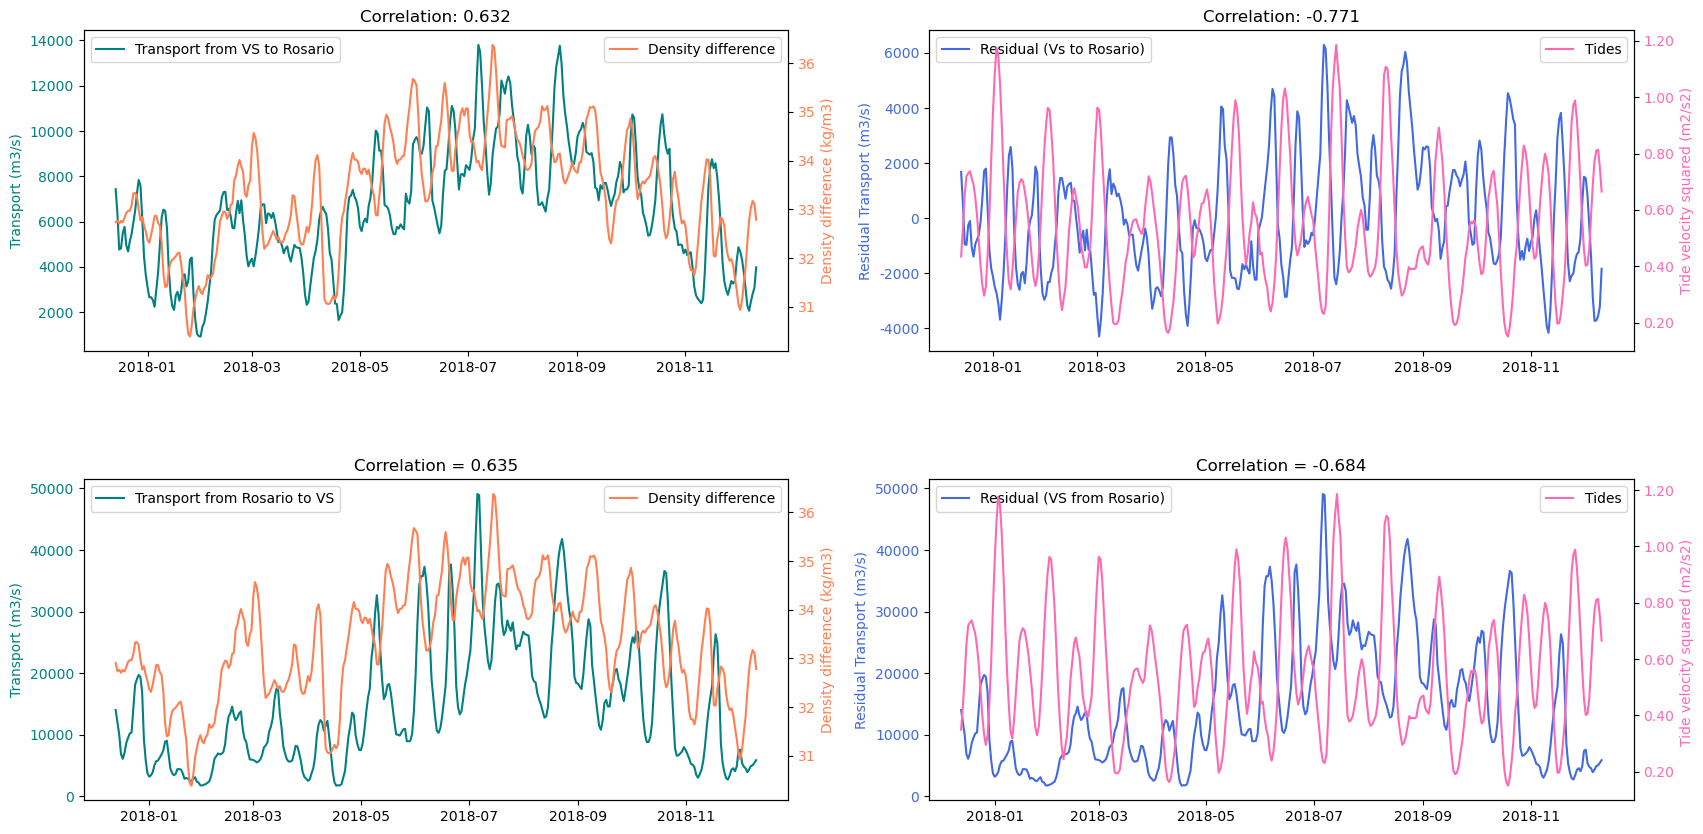

In [77]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(20,10))

ax1.plot(VStoRos_avgd,color1,label='Transport from VS to Rosario')
ax12=ax1.twinx()
ax12.plot(daterosd_sh,densdiff_ros,color2,label='Density difference')
ax1.set_title(f'Correlation: {np.round(corr_VStoRos_dens,3)}')
ax1.set_ylabel('Transport (m3/s)',color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax1.legend(loc=2)
ax12.legend()
ax12.set_yticklabels(np.arange(32,36,2),color=color2)
ax12.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax1.set_yticklabels(np.arange(2500,12500,2500),color=color1)
ax1.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax2.plot(res_ros,color=color3,label='Residual (Vs to Rosario)')
ax22=ax2.twinx()
ax22.plot(daterosd_sh,tides_ros,color=color4,label='Tides')
ax2.set_title(f'Correlation: {np.round(corr_VStoRos_tides,3)}')
ax22.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax2.set_ylabel('Residual Transport (m3/s)',color=color3)
ax2.legend(loc=2)
ax22.legend()
ax22.set_yticklabels(np.arange(0.2,1.2,0.2),color=color4)
ax22.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax2.set_yticklabels(np.arange(-4000,6000,2000),color=color3)
ax2.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax3.plot(RostoVS_avg.dropna(),color=color1,label='Transport from Rosario to VS')
ax32 = ax3.twinx()
ax32.plot(date_RostoVS_dens,densdiff_ros_surf,color=color2,label='Density difference')
ax3.set_title(f'Correlation = {np.round(corr_RostoVS_dens,3)}')
ax3.set_ylabel('Transport (m3/s)',color=color1)
ax32.set_ylabel('Density difference (kg/m3)',color=color2)
ax3.legend(loc=2)
ax32.legend()
ax32.set_yticklabels(np.arange(32,36,2),color=color2)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax3.set_yticklabels(np.arange(10000,50000,10000),color=color1)
ax3.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax4.plot(RostoVS_avg.dropna(),color=color3,label='Residual (VS from Rosario)')
ax42=ax4.twinx()
ax42.plot(date_RostoVS_tides,tidesros_surf,color=color4,label='Tides')
ax4.set_title(f'Correlation = {np.round(corr_RostoVS_tides,3)}')
ax4.legend(loc=2)
ax42.legend()
ax4.set_ylabel('Residual Transport (m3/s)',color=color3)
ax42.set_ylabel('Tide velocity squared (m2/s2) ',color=color4)
ax42.set_yticklabels(np.arange(0.25,1,0.25),color=color4)
ax42.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax4.set_yticklabels(np.arange(20000,40000,20000),color=color3)
ax4.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

fig.subplots_adjust(hspace=0.4)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/2018_rosVS_correlation.png',bbox_inches='tight')

### Density difference comparison

In [78]:
dateharo_sh = list(VStoHaro_avg.dropna().index)

mask = np.isin(datelist_dens,dateharo_sh)
densdiff_harovs = dens_diff_haro[mask]
densdiff_prvs = dens_diff[mask]

corr_harovs,p = stats.spearmanr(densdiff_harovs,VStoHaro_avg.dropna())
corr_prvs,p = stats.spearmanr(densdiff_prvs,VStoHaro_avg.dropna())

In [79]:
corr_harovs,corr_prvs

(0.8117715430762816, 0.8233476382140206)

Correlation is very similar using density diff between vs/pr and haro/vs. But slightly higher when using prvs

Compare Rosario

In [80]:
dateros_sh = list(VStoRos_avg.dropna().index)

mask = np.isin(datelist_dens,dateros_sh)
densdiff_rosvs = dens_diff_ros[mask]
densdiff_prvs = dens_diff[mask]

corr_rosvs,p = stats.spearmanr(densdiff_rosvs,VStoRos_avg.dropna())
corr_prvs,p = stats.spearmanr(densdiff_prvs,VStoRos_avg.dropna())

In [81]:
corr_rosvs,corr_prvs

(0.6321486148206389, 0.7654843900449124)

For Rosario, significantly higher when using dens diff b/w pr and vs. 

Compare SJC

In [82]:
datesjc_sh = list(VStoSJC_avg.dropna().index)

mask = np.isin(datelist_dens,datesjc_sh)
densdiff_sjcvs = dens_diff_sjc[mask]
densdiff_prvs = dens_diff[mask]

corr_sjcvs,p = stats.spearmanr(densdiff_sjcvs,VStoSJC_avg.dropna())
corr_prvs,p = stats.spearmanr(densdiff_prvs,VStoSJC_avg.dropna())

In [83]:
corr_sjcvs,corr_prvs

(-0.538564436463709, 0.5307174908594593)

Correlation seems significantly stronger using pr/vs one.

## San Juan / Gulf Islands Region

In [84]:
PRtoRosl = sectransp_2018['for_jan18_PR'][4]
PRtoRosbl = sectransp_2018['backrosPR_jan18'][4]

PRtoRos = pd.Series(PRtoRosl,index=datelist_vs)
PRtoRosb = pd.Series(PRtoRosbl,index=datelist_vs)

In [85]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoRos,age_2018['for_jan18_PR'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoRosb,age_2018['backrosPR_jan18'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.77:
            print (base, factor, corr_arr[i, j])

0.0 0.15000000000000002 0.7701815367122465
0.0 0.2 0.7702867266547883
0.05 0.15000000000000002 0.7753138873260095
0.05 0.2 0.7707526130998583
0.1 0.2 0.7720587924935333
0.25 0.1 0.7765351622866922
0.30000000000000004 0.1 0.7744933879189333
0.4 0.15000000000000002 0.7720012417498667
0.45 0.15000000000000002 0.7788776323136748
0.5 0.15000000000000002 0.7702378893907237
0.65 0.05 0.7744933879189333
0.9500000000000001 0.1 0.7765829103988042


[0.45] [0.15]


Text(0.5, 0, 'Base')

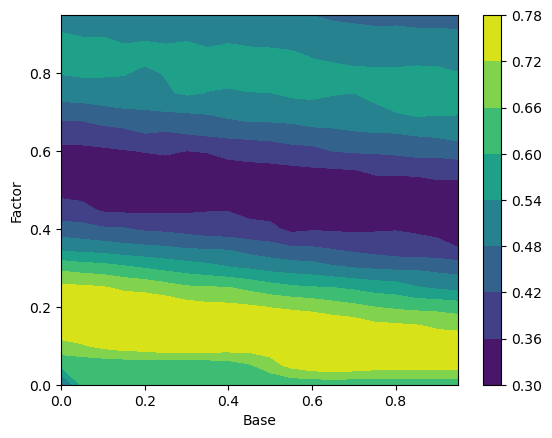

In [86]:
i_base_ros,i_factor_ros = np.where(corr_arr==np.max(corr_arr))

base_ros = base_arr[i_base_ros]
factor_ros = factor_arr[i_factor_ros]

print(base_arr[i_base_ros],factor_arr[i_factor_ros])

x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

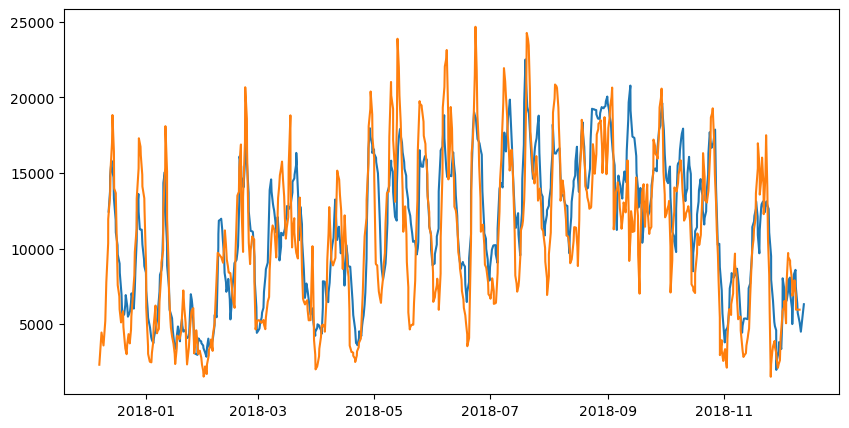

In [87]:
PRtoRos_sh = shift_time(PRtoRos,age_2018['for_jan18_PR'][4],datelist_vs,base_arr[i_base_ros][0],factor_ros[0])
PRtoRos_bsh = shift_time(PRtoRosb,age_2018['backrosPR_jan18'][4],datelist_vs,-base_ros[0],-factor_ros[0])

PRtoRos_m,PRtoRos_m,c,PRtoRos_avg = merge(PRtoRos_sh,PRtoRos_bsh)
plt.subplots(figsize=(10,5))
plt.plot(SJCtoVS_m.dropna())
plt.plot(SJCtoVSb_m.dropna())
# plt.plot(SJCtoVS_avg.dropna())

In [88]:
daterosPR = list(PRtoRos_avg.dropna().index)
mask = np.isin(datelist_dens,daterosPR)

densdiff_rosPR = dens_diff[mask]

corr_rosPR_dd,p = stats.spearmanr(densdiff_rosPR,PRtoRos_avg.dropna())
print(corr_rosPR_dd)

0.7819346282609047


In [89]:
slope,intercept = np.polyfit(densdiff_rosPR,PRtoRos_avg.dropna(),1)
ddline_rosPR = densdiff_rosPR*slope+intercept
res_rosPR = PRtoRos_avg.dropna()-ddline_rosPR

mask = np.isin(datelist_tides,daterosPR)
tides_rosPR = tides.vozocrtx[mask]

corr_rosPR_tides,p = stats.spearmanr(tides_rosPR,PRtoRos_avg.dropna())
corr_rosPR_tidesr,p = stats.spearmanr(tides_rosPR,res_rosPR)
corr_rosPR_tides,corr_rosPR_tidesr

(0.13702611211951185, 0.2645399432448)

### Haro

In [90]:
PRtoHarol = sectransp_2018['for_jan18_PR'][6]
PRtoHarobl = sectransp_2018['backharoPR_jan18'][6]

PRtoHaro = pd.Series(PRtoHarol,index=datelist_vs)
PRtoHarob = pd.Series(PRtoHarobl,index=datelist_vs)

In [91]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoHaro,age_2018['for_jan18_PR'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoHarob,age_2018['backharoPR_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.75:
            print (base, factor, corr_arr[i, j])

0.1 0.15000000000000002 0.7587112708676396
0.15000000000000002 0.15000000000000002 0.7587007665988275
0.35000000000000003 0.1 0.7510080214567405
0.4 0.1 0.7587112708676396
0.45 0.1 0.7555351675630527
0.7000000000000001 0.05 0.7587112708676396


In [92]:
i_base_haro,i_factor_haro = np.where(corr_arr==np.max(corr_arr))

base_haro = base_arr[i_base_haro]
factor_haro = factor_arr[i_factor_haro]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[0.1 0.4 0.7] [0.15 0.1  0.05]


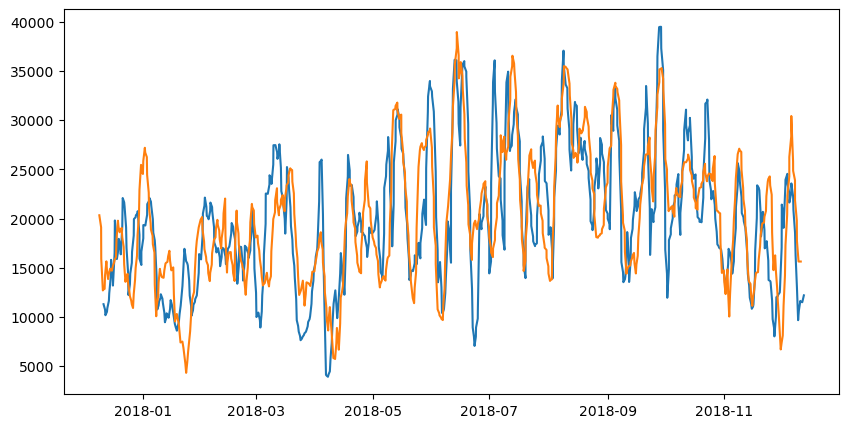

In [93]:
PRtoHaro_sh = shift_time(PRtoHaro,age_2018['for_jan18_PR'][6],datelist_vs,base_arr[i_base_haro][0],factor_haro[0])
PRtoHaro_bsh = shift_time(PRtoHarob,age_2018['backharoPR_jan18'][6],datelist_vs,-base_haro[0],-factor_haro[0])

PRtoHaro_m,PRtoHaro_bm,c,PRtoHaro_avg = merge(PRtoHaro_sh,PRtoHaro_bsh)
plt.subplots(figsize=(10,5))
plt.plot(PRtoHaro_m.dropna())
plt.plot(PRtoHaro_bm.dropna())
# plt.plot(SJCtoVS_avg.dropna())

In [94]:
date_haroPR = list(PRtoHaro_avg.dropna().index)

mask = np.isin(datelist_dens,date_haroPR)
densdiff_haroPR = dens_diff[mask]

corr_haroPR_dd,p = stats.spearmanr(densdiff_haroPR,PRtoHaro_avg.dropna())
print(corr_haroPR_dd)

0.6988556918042659


In [95]:
slope,intercept = np.polyfit(densdiff_haroPR,PRtoHaro_avg.dropna(),1)
ddline_haroPR = slope*densdiff_haroPR+intercept
res_haroPR = PRtoHaro_avg.dropna()-ddline_haroPR

mask = np.isin(datelist_tides,date_haroPR)
tides_haroPR = tides.vozocrtx[mask]

corr_haroPR_tides,p = stats.spearmanr(tides_haroPR,PRtoHaro_avg.dropna())
corr_haroPR_tidesr,p = stats.spearmanr(tides_haroPR,res_haroPR)
corr_haroPR_tides,corr_haroPR_tidesr

(0.1269530604136488, 0.23103056835372132)

Look at the deep to see if positive correlation is still happening

### Deep - Haro to PR

In [96]:
HarotoPRl = sectransp_2018['forharoPR_jan18'][6]
HarotoPRbl = sectransp_2018['backPR_jan18'][6]

HarotoPR = pd.Series(HarotoPRl,index=datelist_vs)
HarotoPRb = pd.Series(HarotoPRbl,index=datelist_vs)

In [97]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(HarotoPR,age_2018['forharoPR_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(HarotoPRb,age_2018['backPR_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.83:
            print (base, factor, corr_arr[i, j])

0.0 0.4 0.8300401808582852
0.05 0.35000000000000003 0.8309729607213113
0.05 0.4 0.8301550126311297
0.1 0.35000000000000003 0.8328435755446595
0.15000000000000002 0.35000000000000003 0.8337030447639956
0.2 0.35000000000000003 0.8319678621355031
0.25 0.35000000000000003 0.8318684387315255
0.30000000000000004 0.35000000000000003 0.8339109001310602
0.35000000000000003 0.30000000000000004 0.8305564549124755
0.35000000000000003 0.35000000000000003 0.832470020061732
0.4 0.30000000000000004 0.8327712564431987
0.4 0.35000000000000003 0.832335810457862
0.45 0.30000000000000004 0.8335931569050318
0.45 0.35000000000000003 0.8313232936012412
0.5 0.30000000000000004 0.8323732984689237
0.5 0.35000000000000003 0.8314693028327681
0.55 0.30000000000000004 0.8317856946818921
0.6000000000000001 0.30000000000000004 0.83317311079642
0.65 0.30000000000000004 0.8324211489130181
0.7000000000000001 0.25 0.8311565617730526
0.7000000000000001 0.30000000000000004 0.8332605603913803
0.8 0.30000000000000004 0.831289

In [98]:
i_base_harod,i_factor_harod = np.where(corr_arr==np.max(corr_arr))

base_harod = base_arr[i_base_harod]
factor_harod = factor_arr[i_factor_harod]

print(base_arr[i_base_harod],factor_arr[i_factor_harod])

[0.95] [0.25]


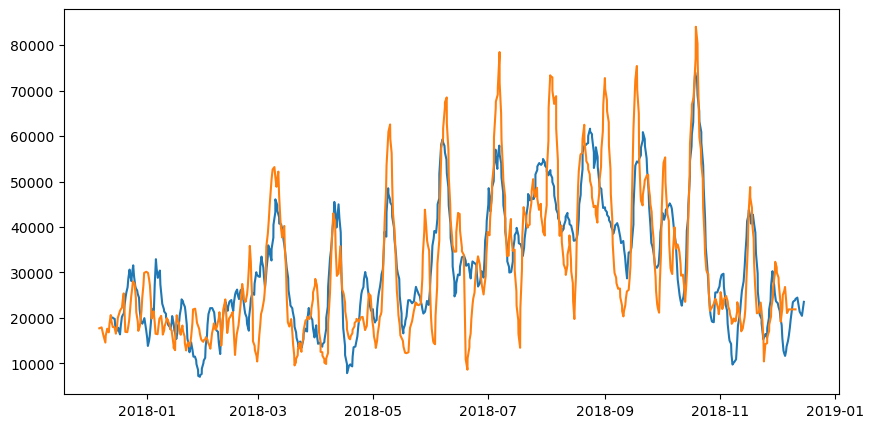

In [99]:
HarotoPR_sh = shift_time(HarotoPR,age_2018['forharoPR_jan18'][6],datelist_vs,base_arr[i_base_harod][0],factor_harod[0])
HarotoPR_bsh = shift_time(HarotoPRb,age_2018['backPR_jan18'][6],datelist_vs,-base_harod[0],-factor_harod[0])

HarotoPR_m,HarotoPR_bm,c,HarotoPR_avg = merge(HarotoPR_sh,HarotoPR_bsh)
plt.subplots(figsize=(10,5))
plt.plot(HarotoPR_m.dropna())
plt.plot(HarotoPR_bm.dropna())
# plt.plot(SJCtoVS_avg.dropna())

In [100]:
date_haroPRd = list(HarotoPR_avg.dropna().index)

mask = np.isin(datelist_dens,date_haroPRd)
densdiff_haroPRd = dens_diff[mask]

corr_HarotoPR_dd,p = stats.spearmanr(densdiff_haroPRd,HarotoPR_avg.dropna())
print(corr_HarotoPR_dd)

0.6542269884811321


In [101]:
slope,intercept = np.polyfit(densdiff_haroPRd,HarotoPR_avg.dropna(),1)
ddline_HarotoPR = slope*densdiff_haroPRd+intercept
res_HarotoPR = HarotoPR_avg.dropna() - ddline_HarotoPR

mask = np.isin(datelist_tides,date_haroPRd)
tides_HarotoPR = tides.vozocrtx[mask]

corr_HarotoPR_tides,p = stats.spearmanr(tides_HarotoPR,res_HarotoPR)

print(corr_HarotoPR_tides)

-0.5997094317034046


### Deep - Rosario

In [102]:
RostoPRl = sectransp_2018['forrosPR_jan18'][4]
RostoPRbl = sectransp_2018['backPR_jan18'][4]

RostoPR = pd.Series(RostoPRl,index=datelist_vs)
RostoPRb = pd.Series(RostoPRbl,index=datelist_vs)

RostoPR_idx = np.where(np.isnan(np.array(age_2018['backPR_jan18'][4])))[0]
agerosb_dropped = pd.Series(age_2018['backPR_jan18'][4],index=datelist_vs).dropna()
ageros_dropped= pd.Series(age_2018['forrosPR_jan18'][4],index=datelist_vs).dropna()

ageros_droppedl = list(ageros_dropped)
agerosb_droppedl= list(agerosb_dropped)

dateros_dropped = list(ageros_dropped.index)
daterosb_dropped = list(agerosb_dropped.index)
dateros = list(RostoPR.index)
mask = np.isin(daterosb_dropped,dateros_dropped)
date_dropped = np.array(daterosb_dropped)[mask]

mask = np.isin(dateros,date_dropped)
RostoPRb_dropped = RostoPRb[mask]
RostoPR_dropped = RostoPR[mask]

mask = np.isin(dateros_dropped,date_dropped)
ageros = ageros_dropped[mask]
mask = np.isin(daterosb_dropped,date_dropped)
agerosb = agerosb_dropped[mask]

In [103]:
np.where(np.isnan(np.array(age_2018['backPR_jan18'][6])))[0],np.where(np.isnan(np.array(age_2018['forharoPR_jan18'][6])))[0]

(array([], dtype=int64), array([], dtype=int64))

In [104]:
# Loop through different base and factors to find which combination maximizes the correlation
factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(RostoPR_dropped,ageros_droppedl,date_dropped,base,factor)
        dfr2 = shift_time(RostoPRb_dropped,agerosb_droppedl,date_dropped,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

0.0 0.25 0.7713404899736069
0.0 0.30000000000000004 0.7693146213108191
0.05 0.25 0.7691119824818802
0.1 0.25 0.7647183639864018
0.15000000000000002 0.25 0.7660952919702824
0.15000000000000002 0.30000000000000004 0.7616636684043577
0.2 0.2 0.7660628551333951
0.2 0.25 0.7732713269721749
0.2 0.30000000000000004 0.7623391187942619
0.25 0.2 0.7687806906384494
0.25 0.25 0.7735276789638348
0.25 0.30000000000000004 0.7613960198522816
0.30000000000000004 0.2 0.7611778384313995
0.30000000000000004 0.30000000000000004 0.7615401661751283
0.55 0.2 0.7620419416593289
0.6000000000000001 0.2 0.7645162742936134


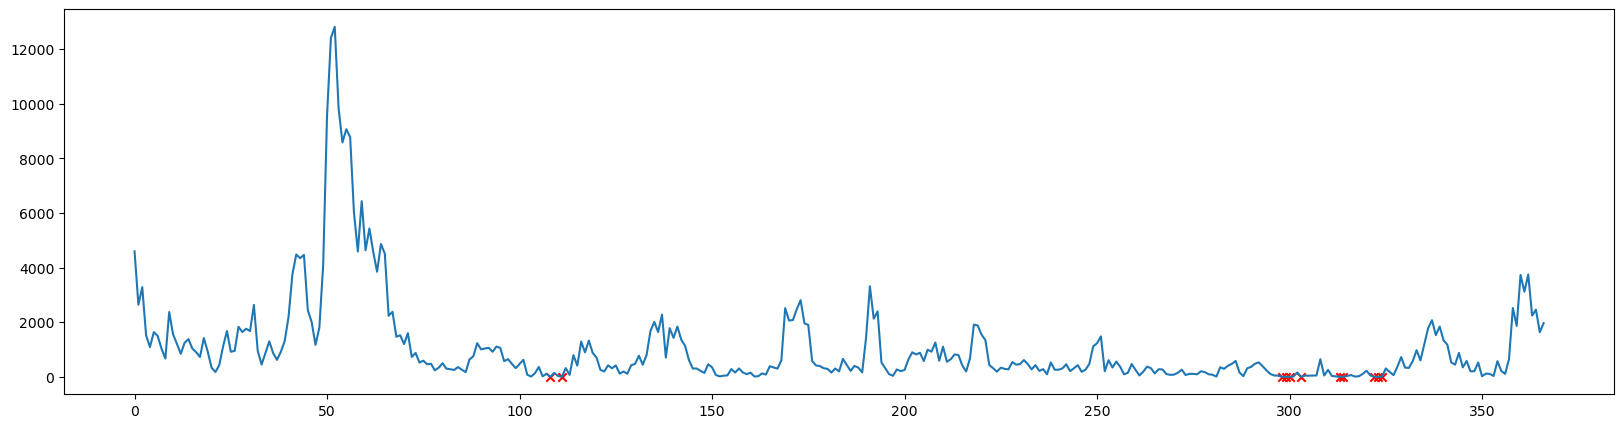

In [105]:
nan_idx = np.where(np.array(np.isnan(age_2018['backPR_jan18'][4])))[0]

plt.subplots(figsize=(20,5))
plt.plot(sectransp_2018['backPR_jan18'][4])
plt.scatter(nan_idx,np.linspace(0,0,len(nan_idx)),color='r',marker='x')

In [106]:
i_base_rosd,i_factor_rosd = np.where(corr_arr==np.max(corr_arr))

base_rosd = base_arr[i_base_rosd]
factor_rosd = factor_arr[i_factor_rosd]

print(base_arr[i_base_rosd],factor_arr[i_factor_rosd])

[0.25] [0.25]


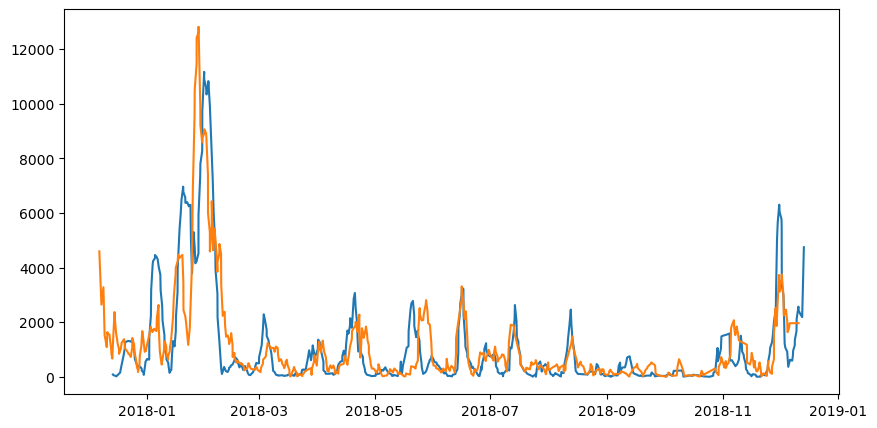

In [107]:
RostoPR_sh = shift_time(RostoPR_dropped,ageros_droppedl,date_dropped,base_arr[i_base_rosd][0],factor_rosd[0])
RostoPR_bsh = shift_time(RostoPRb_dropped,agerosb_droppedl,date_dropped,-base_harod[0],-factor_harod[0])

RostoPR_m,RostoPR_bm,c,RostoPR_avg = merge(RostoPR_sh,RostoPR_bsh)
plt.subplots(figsize=(10,5))
plt.plot(RostoPR_m.dropna())
plt.plot(RostoPR_bm.dropna())
# plt.plot(SJCtoVS_avg.dropna())

In [108]:
dateros_final = list(RostoPR_avg.dropna().index)

mask = np.isin(datelist_dens,dateros_final)
densdiff_RostoPR = dens_diff[mask]
date_RostoPR_dens = np.array(datelist_dens)[mask]

corr_RostoPR_dens,p = stats.spearmanr(densdiff_RostoPR,RostoPR_avg.dropna())
print(corr_RostoPR_dens)

mask = np.isin(datelist_tides,dateros_final)
tides_RostoPR = tides.vozocrtx[mask]
date_RostoPR_tides = np.array(datelist_tides)[mask]

corr_RostoPR_tides,p = stats.spearmanr(tides_RostoPR,RostoPR_avg.dropna())
print(corr_RostoPR_tides)

-0.413760890334255
0.40038436473841055


/tmp/ipykernel_31844/3208409808.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,14,2),color=color2)
/tmp/ipykernel_31844/3208409808.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(-10000,10000,5000),color=color1)
/tmp/ipykernel_31844/3208409808.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22.set_yticklabels(np.arange(4,14,2),color=color4)
/tmp/ipykernel_31844/3208409808.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(-20000,40000,1000),color=color3)
/tmp/ipykernel_31844/3208409808.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(4,14,2),color=color2)
/tmp/ipykernel_31844/3208409808.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels

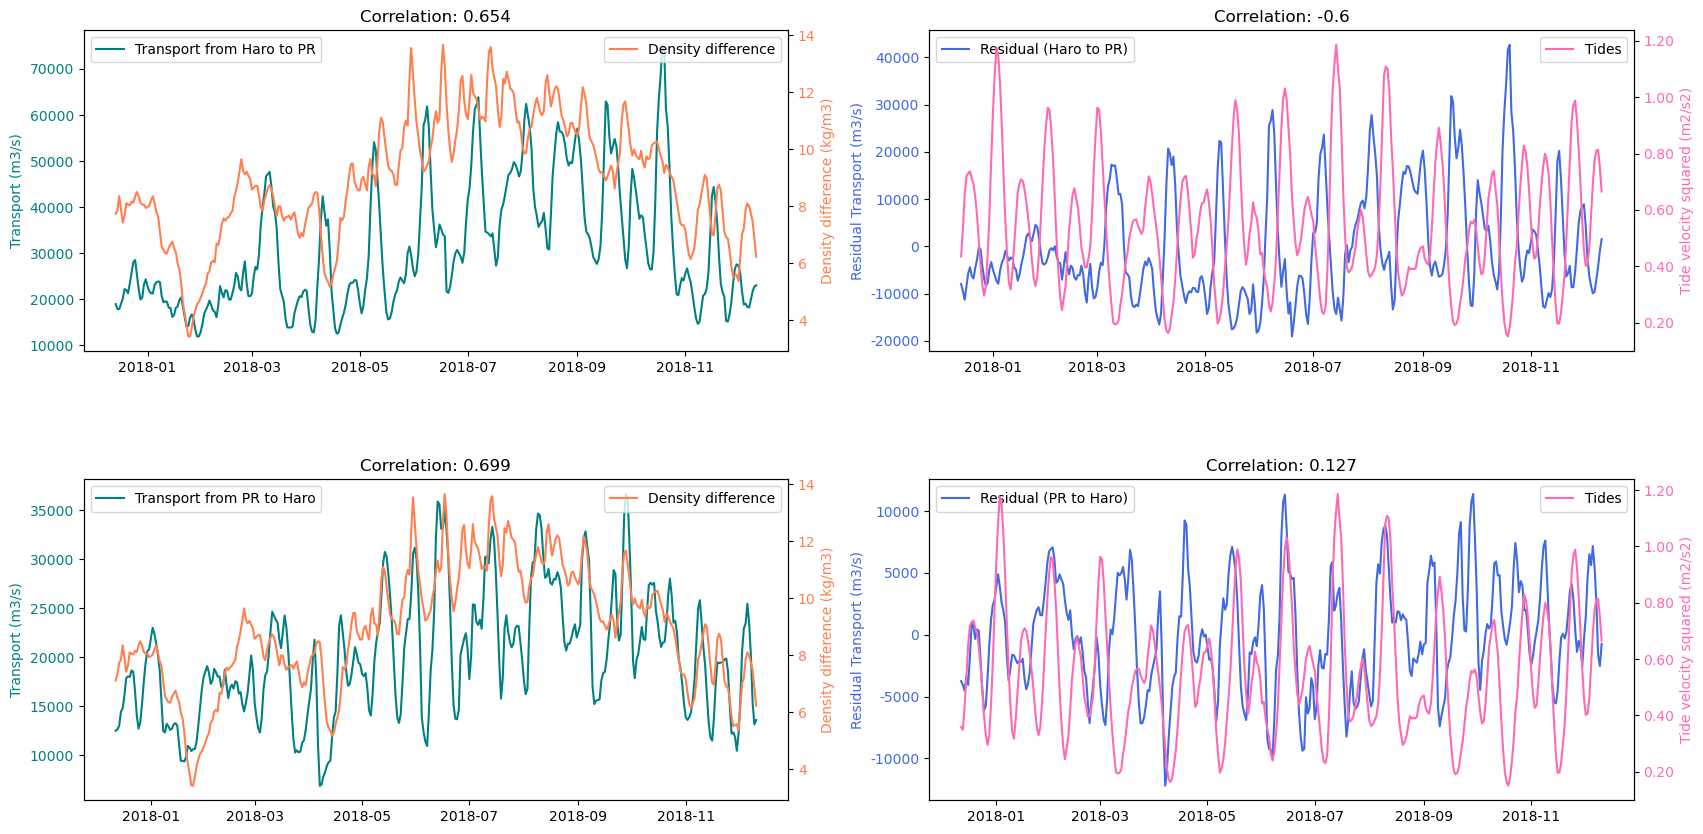

In [109]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(20,10))

ax1.plot(HarotoPR_avg.dropna(),color1,label='Transport from Haro to PR')
ax12=ax1.twinx()
ax12.plot(date_haroPRd,densdiff_haroPRd,color2,label='Density difference')
ax1.set_title(f'Correlation: {np.round(corr_HarotoPR_dd,3)}')
ax1.set_ylabel('Transport (m3/s)',color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax1.legend(loc=2)
ax12.legend()
ax12.set_yticklabels(np.arange(4,14,2),color=color2)
ax12.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax1.set_yticklabels(np.arange(-10000,10000,5000),color=color1)
ax1.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))


ax2.plot(res_HarotoPR,color=color3,label='Residual (Haro to PR)')
ax22=ax2.twinx()
ax22.plot(date_haroPRd,tides_HarotoPR,color=color4,label='Tides')
ax2.set_title(f'Correlation: {np.round(corr_HarotoPR_tides,3)}')
ax22.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax2.set_ylabel('Residual Transport (m3/s)',color=color3)
ax2.legend(loc=2)
ax22.legend()
ax22.set_yticklabels(np.arange(4,14,2),color=color4)
ax22.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax2.set_yticklabels(np.arange(-20000,40000,1000),color=color3)
ax2.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax3.plot(PRtoHaro_avg.dropna(),color1,label='Transport from PR to Haro')
ax32=ax3.twinx()
ax32.plot(date_haroPR,densdiff_haroPR,color2,label='Density difference')
ax3.set_title(f'Correlation: {np.round(corr_haroPR_dd,3)}')
ax3.set_ylabel('Transport (m3/s)',color=color1)
ax32.set_ylabel('Density difference (kg/m3)',color=color2)
ax3.legend(loc=2)
ax32.legend()
ax32.set_yticklabels(np.arange(4,14,2),color=color2)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax3.set_yticklabels(np.arange(10000,35000,5000),color=color1)
ax3.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax4.plot(res_haroPR,color=color3,label='Residual (PR to Haro)')
ax42=ax4.twinx()
ax42.plot(date_haroPR,tides_haroPR,color=color4,label='Tides')
ax4.set_title(f'Correlation: {np.round(corr_haroPR_tides,3)}')
ax42.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax4.set_ylabel('Residual Transport (m3/s)',color=color3)
ax4.legend(loc=2)
ax42.legend()
ax42.set_yticklabels(np.arange(0.2,1.2,0.2),color=color4)
ax42.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax4.set_yticklabels(np.arange(-10000,10000,5000),color=color3)
ax4.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

fig.subplots_adjust(hspace=0.4)

# fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/2018_rosVS_correlation.png',bbox_inches='tight')

/tmp/ipykernel_31844/2932383215.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,14,2),color=color2)
/tmp/ipykernel_31844/2932383215.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0,10000,2000),color=color1)
/tmp/ipykernel_31844/2932383215.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22.set_yticklabels(np.arange(4,14,2),color=color4)
/tmp/ipykernel_31844/2932383215.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.arange(0,10000,2000),color=color3)
/tmp/ipykernel_31844/2932383215.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(4,14,2),color=color2)
/tmp/ipykernel_31844/2932383215.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange

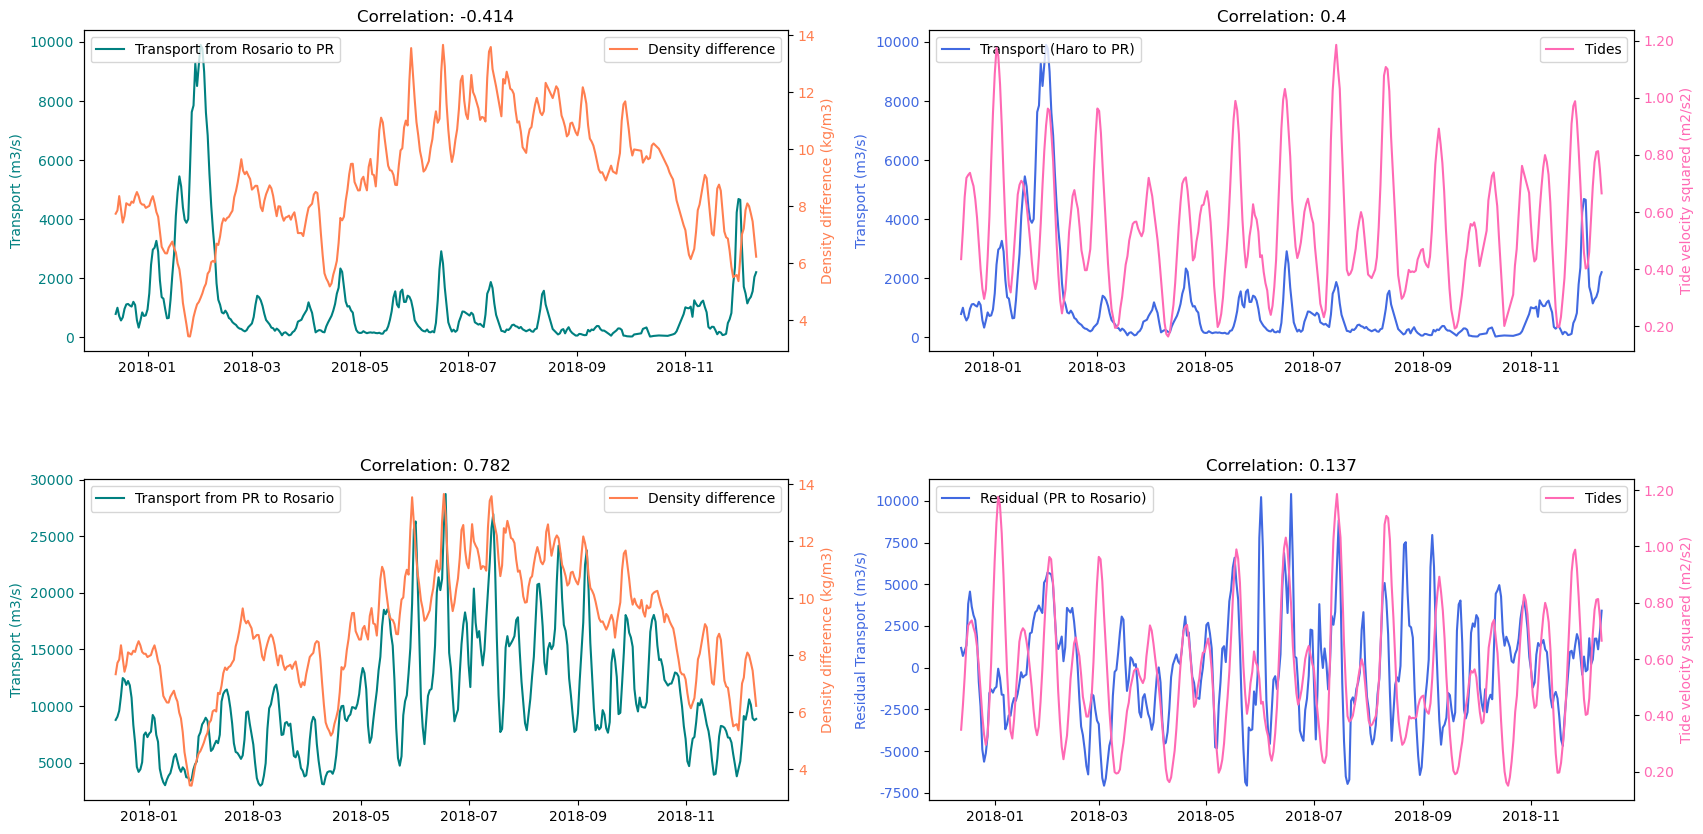

In [110]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(20,10))

ax1.plot(RostoPR_avg.dropna(),color1,label='Transport from Rosario to PR')
ax12=ax1.twinx()
ax12.plot(date_RostoPR_dens,densdiff_RostoPR,color2,label='Density difference')
ax1.set_title(f'Correlation: {np.round(corr_RostoPR_dens,3)}')
ax1.set_ylabel('Transport (m3/s)',color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax1.legend(loc=2)
ax12.legend()
ax12.set_yticklabels(np.arange(4,14,2),color=color2)
ax12.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax1.set_yticklabels(np.arange(0,10000,2000),color=color1)
ax1.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))


ax2.plot(RostoPR_avg.dropna(),color=color3,label='Transport (Haro to PR)')
ax22=ax2.twinx()
ax22.plot(date_RostoPR_tides,tides_RostoPR,color=color4,label='Tides')
ax2.set_title(f'Correlation: {np.round(corr_RostoPR_tides,3)}')
ax22.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax2.set_ylabel('Transport (m3/s)',color=color3)
ax2.legend(loc=2)
ax22.legend()
ax22.set_yticklabels(np.arange(4,14,2),color=color4)
ax22.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax2.set_yticklabels(np.arange(0,10000,2000),color=color3)
ax2.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax3.plot(PRtoRos_avg.dropna(),color1,label='Transport from PR to Rosario')
ax32=ax3.twinx()
ax32.plot(daterosPR,densdiff_rosPR,color2,label='Density difference')
ax3.set_title(f'Correlation: {np.round(corr_rosPR_dd,3)}')
ax3.set_ylabel('Transport (m3/s)',color=color1)
ax32.set_ylabel('Density difference (kg/m3)',color=color2)
ax3.legend(loc=2)
ax32.legend()
ax32.set_yticklabels(np.arange(4,14,2),color=color2)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))
ax3.set_yticklabels(np.arange(5000,30000,5000),color=color1)
ax3.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

ax4.plot(res_rosPR,color=color3,label='Residual (PR to Rosario)')
ax42=ax4.twinx()
ax42.plot(daterosPR,tides_rosPR,color=color4,label='Tides')
ax4.set_title(f'Correlation: {np.round(corr_rosPR_tides,3)}')
ax42.set_ylabel('Tide velocity squared (m2/s2)',color=color4)
ax4.set_ylabel('Residual Transport (m3/s)',color=color3)
ax4.legend(loc=2)
ax42.legend()
ax42.set_yticklabels(np.arange(0.2,1.2,0.2),color=color4)
ax42.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))
ax4.set_yticklabels(np.arange(-75000,10000,2500),color=color3)
ax4.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{0}f}}'))

fig.subplots_adjust(hspace=0.4)

# fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/2018_rosVS_correlation.png',bbox_inches='tight')

### Admiralty

In [113]:
VStoadml = sectransp_2018['for_jan18'][2]
VStoadmbl = sectransp_2018['backadm_jan18'][2]

VStoadm = pd.Series(VStoadml,index=datelist_vs)
VStoadmb = pd.Series(VStoadmbl,index=datelist_vs)

In [118]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoadm,age_2018['for_jan18'][2],datelist_vs,base,factor)
        dfr2 = shift_time(VStoadmb,age_2018['backadm_jan18'][2],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.4:
            print (base, factor, corr_arr[i, j])

0.05 0.2 0.4004494981902622
0.05 0.25 0.40332288925832044
0.1 0.2 0.41482076359596376
0.1 0.25 0.4064679470127645
0.15000000000000002 0.25 0.4024243442011186
0.25 0.2 0.40473160116797113
0.30000000000000004 0.15000000000000002 0.4053490186199495
0.30000000000000004 0.2 0.4063020375814637
0.35000000000000003 0.15000000000000002 0.4030018228137817
0.35000000000000003 0.2 0.40050871667838894
0.45 0.15000000000000002 0.4070881930220726
0.45 0.2 0.40067613613914405
0.5 0.15000000000000002 0.4021372362328901
0.5 0.2 0.40067613613914405
0.55 0.1 0.41482076359596376
0.55 0.2 0.4029768236582981
0.6000000000000001 0.15000000000000002 0.40067613613914405
0.6000000000000001 0.2 0.4029768236582981
0.65 0.1 0.4063020375814637
0.65 0.15000000000000002 0.4029768236582981
0.7000000000000001 0.15000000000000002 0.4029768236582981
0.75 0.1 0.40067613613914405
0.75 0.15000000000000002 0.4029768236582981
0.8 0.1 0.4029768236582981
0.8 0.15000000000000002 0.4029768236582981
0.8500000000000001 0.1 0.40297682

In [120]:
i_base_admd,i_factor_admd = np.where(corr_arr==np.max(corr_arr))

base_admd = base_arr[i_base_admd]
factor_admd = factor_arr[i_factor_admd]

print(base_arr[i_base_admd],factor_arr[i_factor_admd])

[0.1  0.55] [0.2 0.1]


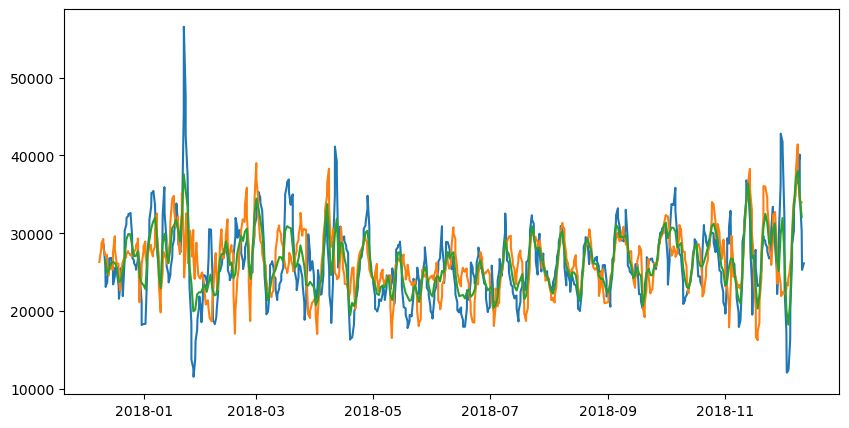

In [121]:
VStoadm_sh = shift_time(VStoadm,age_2018['for_jan18'][2],datelist_vs,base_arr[i_base_admd][0],factor_admd[0])
VStoadm_bsh = shift_time(VStoadmb,age_2018['backadm_jan18'][2],datelist_vs,-base_admd[0],-factor_admd[0])

VStoadm_m,VStoadm_bm,c,VStoadm_avg = merge(VStoadm_sh,VStoadm_bsh)
plt.subplots(figsize=(10,5))
plt.plot(VStoadm_m.dropna())
plt.plot(VStoadm_bm.dropna())
plt.plot(VStoadm_avg.dropna())

These are not well correlated .... Figure out why they don't look the same

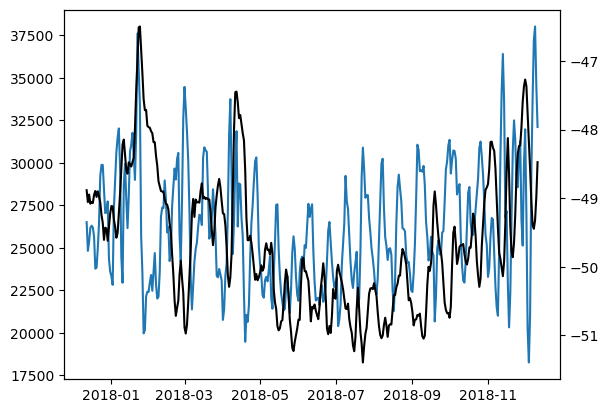

In [137]:
date_adm = list(VStoadm_avg.dropna().index)

mask = np.isin(datelist_dens,date_adm)
densdiff_adm = dens_diff_adm[mask]

corr_adm_dd = stats.spearmanr(densdiff_adm,VStoadm_avg.dropna())

fig,ax = plt.subplots()

ax.plot(VStoadm_avg.dropna())
ax2 =ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_adm,color='k')

Text(0.5, 1.0, 'Correlation: 0.004891134017565637')

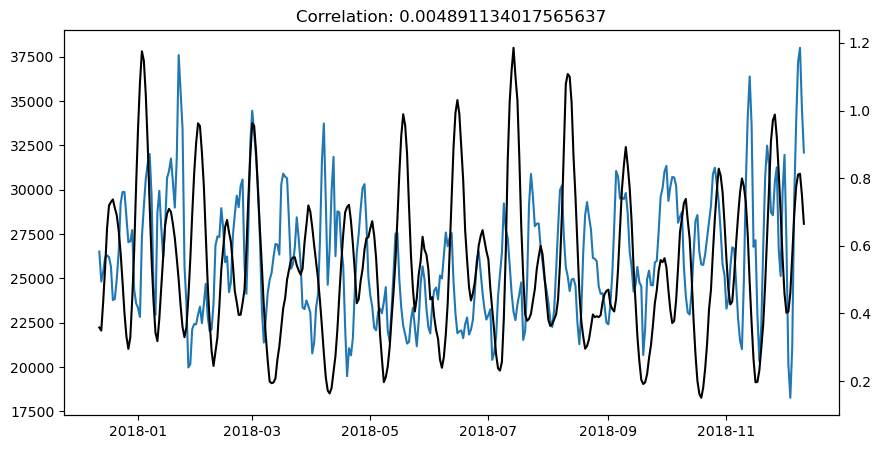

In [142]:
mask = np.isin(datelist_tides,date_adm)
tides_adm = tides.vozocrtx[mask]

corr_adm_dd,p = stats.spearmanr(tides_adm,VStoadm_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoadm_avg.dropna())
ax2 =ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_adm,color='k')
ax.set_title(f'Correlation: {corr_adm_dd}')

#### Surface: Admiralty to VS

In [165]:
admtoVSl = sectransp_2018['backVS_jan18'][2]
admtoVSbl = sectransp_2018['foradm_jan18'][2]

admtoVS = pd.Series(admtoVSl,index=datelist_vs)
admtoVSb = pd.Series(admtoVSbl,index=datelist_vs)

In [167]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(admtoVSb,age_2018['backVS_jan18'][2],datelist_vs,base,factor)
        dfr2 = shift_time(admtoVS,age_2018['foradm_jan18'][2],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.81:
            print (base, factor, corr_arr[i, j])

0.15000000000000002 0.35000000000000003 0.8119267957091983
0.2 0.35000000000000003 0.8128983597117743


In [147]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_arr[i_base_adm],factor_arr[i_factor_adm])

[0.2] [0.35]


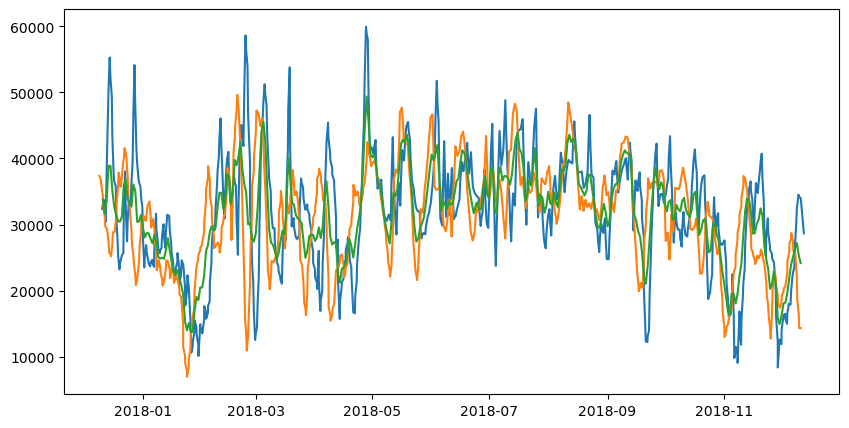

In [168]:
admtoVS_sh = shift_time(admtoVS,age_2018['foradm_jan18'][2],datelist_vs,base_arr[i_base_admd][0],factor_admd[0])
admtoVS_bsh = shift_time(admtoVSb,age_2018['backVS_jan18'][2],datelist_vs,-base_admd[0],-factor_admd[0])

admtoVS_m,admtoVS_bm,c,admtoVS_avg = merge(admtoVS_sh,admtoVS_bsh)
plt.subplots(figsize=(10,5))
plt.plot(admtoVS_m.dropna())
plt.plot(admtoVS_bm.dropna())
plt.plot(admtoVS_avg.dropna())

#### Correlation with density difference

Text(0.5, 1.0, 'Admiralty to VS, correlation: 0.72')

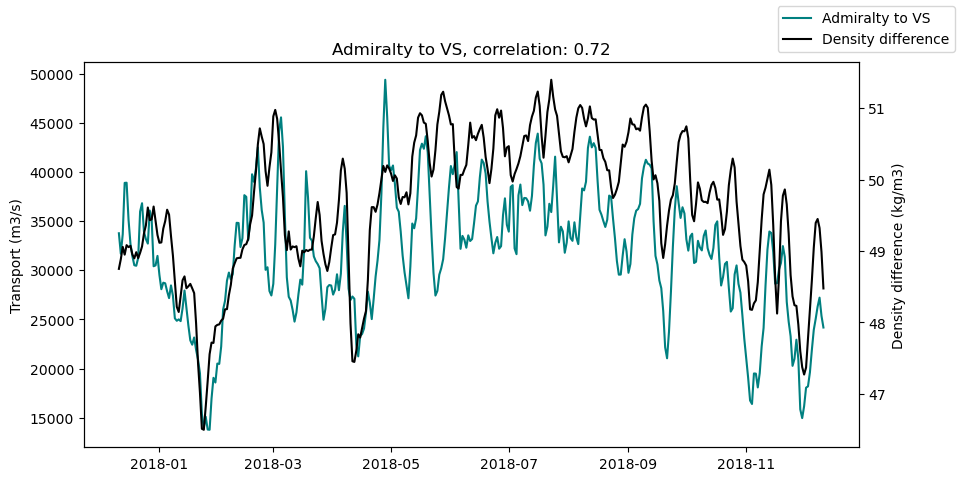

In [178]:
date_admtoVS = list(admtoVS_avg.dropna().index)

mask = np.isin(datelist_dens,date_admtoVS)
densdiff_admtoVS = dens_diff_adm[mask]

corr,p = stats.spearmanr(densdiff_admtoVS,admtoVS_avg.dropna())
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(admtoVS_avg.dropna(),color='teal',label='Admiralty to VS')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_admtoVS,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()
ax.set_title(f'Admiralty to VS, correlation: {np.round(corr,2)}')

In [184]:
slope,intercept = np.polyfit(densdiff_admtoVS,admtoVS_avg.dropna(),1)

ddline = slope*densdiff_admtoVS+intercept
res = admtoVS_avg.dropna() - ddline

mask = np.isin(datelist_tides,date_admtoVS)
tides_admtoVS = tides.vozocrtx[mask]
corr,p = stats.spearmanr(tides_admtoVS,res)


0.005464154527058572

0.8725050986674642


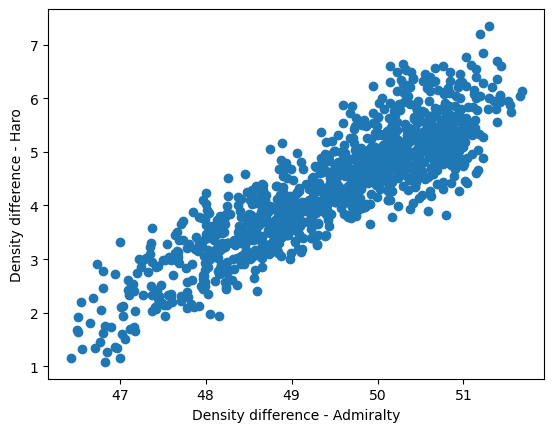

<Figure size 640x480 with 0 Axes>

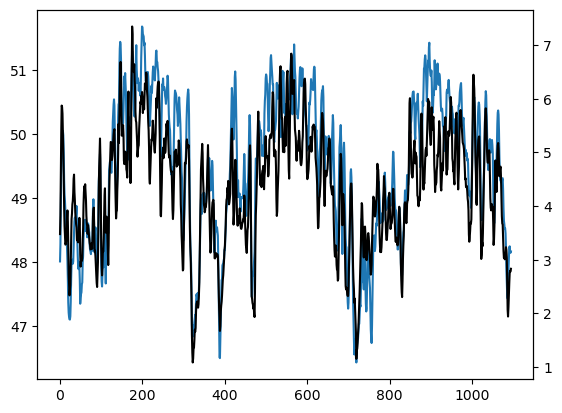

In [164]:
corr, p = stats.spearmanr(dens_diff_adm,dens_diff_haro)
print(corr)

plt.scatter(dens_diff_adm,dens_diff_haro)
plt.xlabel('Density difference - Admiralty')
plt.ylabel('Density difference - Haro')

plt.figure()
fig,ax = plt.subplots()
ax.plot(dens_diff_adm)
ax2 = ax.twinx()
ax2.plot(dens_diff_haro,color='k')